In [1]:
!conda install -y -q pymssql

Retrieving notices: ...working... DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/notices.json HTTP/1.1" 404 None
done
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-arm64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarc

In [1]:
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymssql
import numpy as np
from datetime import timedelta
from matplotlib.ticker import FuncFormatter


In [2]:
con = pymssql.connect(server='localhost',user='SA',password='{Ouss@ma007}',database='YML3')
cursor=con.cursor()



/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/3458540008.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


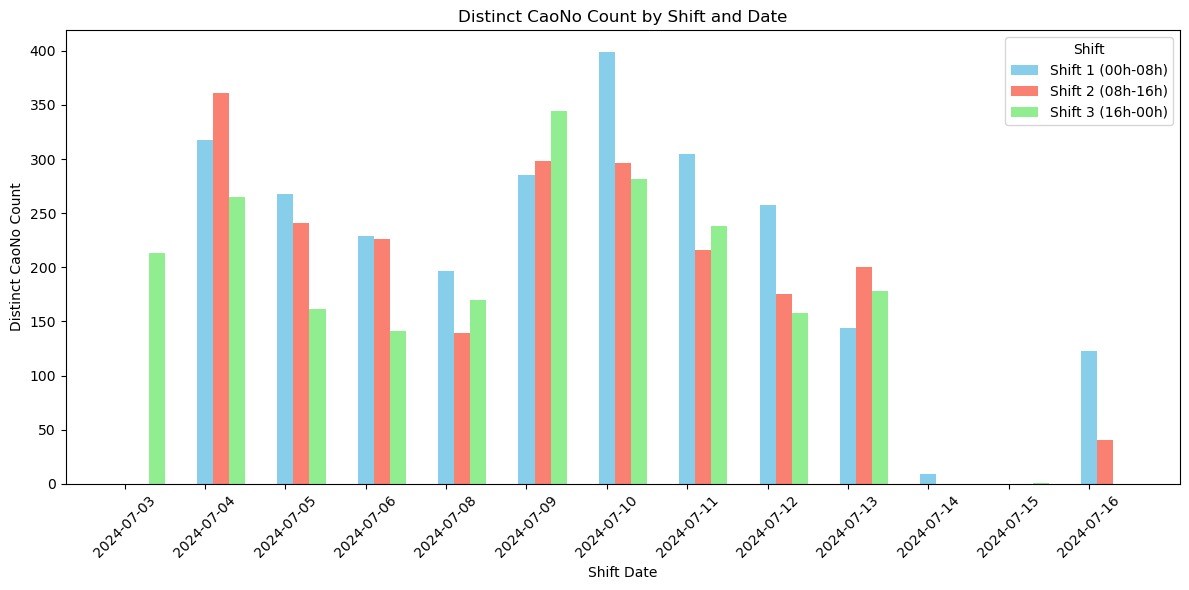

In [58]:
# Define the SQL query with conditions
query = """
SELECT
    Shift,
    ShiftDate,
    COUNT(DISTINCT caono) AS DistinctCaoNoCount
FROM
    [YML3].[dbo].[YMT_2]
WHERE
    Seq = 1
    AND isFilAvail = 1
    AND ProdProgress = 500
    and ActionStatus='Finished/Cancelled'
GROUP BY
    Shift,
    ShiftDate
ORDER BY
    ShiftDate, Shift;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql(query, con)


# Pivot the data to have Shifts as columns and ShiftDates as index
pivot_df = df.pivot(index='ShiftDate', columns='Shift', values='DistinctCaoNoCount').fillna(0)

# Plotting the data
plt.figure(figsize=(12, 6))

# Get unique dates and shifts
dates = pivot_df.index
shifts = pivot_df.columns

# Define colors for each shift
colors = ['skyblue', 'salmon', 'lightgreen']

# Plot each shift separately with different colors
for i, shift in enumerate(shifts):
    plt.bar(np.arange(len(dates)) + 0.2 * i, pivot_df[shift], width=0.2, align='center', label=f'Shift {shift}', color=colors[i])

plt.xlabel('Shift Date')
plt.ylabel('Distinct CaoNo Count')
plt.title('Distinct CaoNo Count by Shift and Date')
plt.xticks(np.arange(len(dates)), dates, rotation=45)
plt.legend(title='Shift')
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/22221425.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


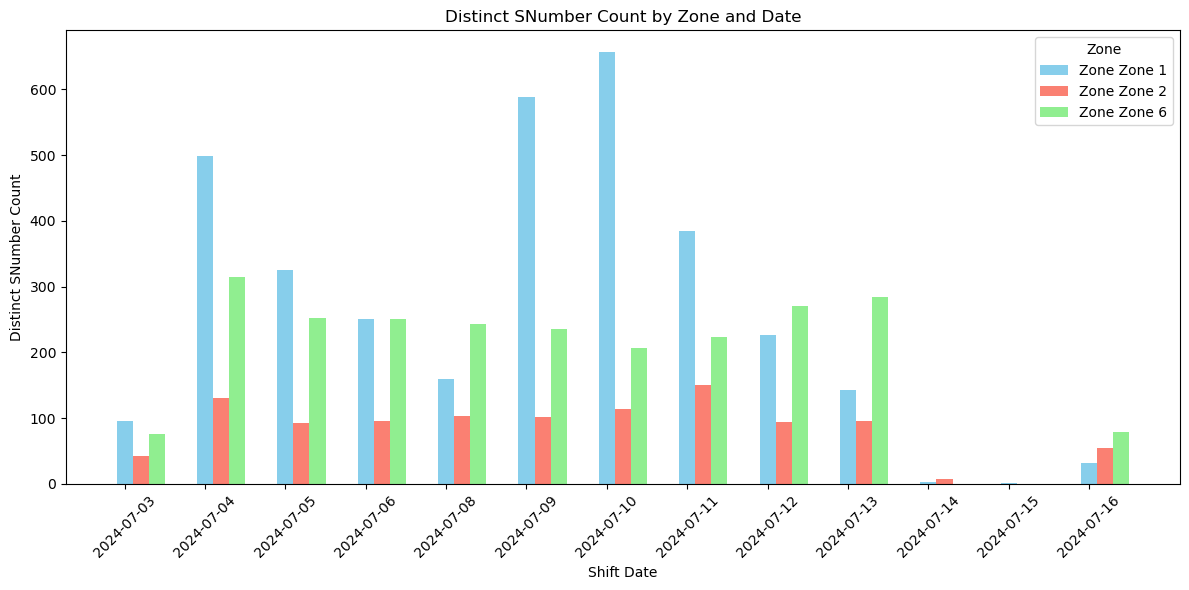

In [57]:
# Define the SQL query with conditions
query = """
SELECT
    Machines_Zone,
    ShiftDate,
    COUNT(DISTINCT caoNo) AS DistinctCaoNumCount
FROM
    YMT_2
WHERE
    Seq = 1
    AND isFilAvail = 1
    AND ProdProgress = 500
    and ActionStatus='Finished/Cancelled'

GROUP BY
    Machines_Zone,
    ShiftDate
ORDER BY
    ShiftDate, Machines_Zone;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql(query, con)

# Pivot the data to have Zones as columns and ShiftDates as index
pivot_df = df.pivot(index='ShiftDate', columns='Machines_Zone', values='DistinctCaoNumCount').fillna(0)

# Plotting the data
plt.figure(figsize=(12, 6))

# Get unique dates and zones
dates = pivot_df.index
zones = pivot_df.columns

# Define colors for each zone
colors = ['skyblue', 'salmon', 'lightgreen', 'orchid', 'gold', 'plum'] 

# Plot each zone separately with different colors
for i, zone in enumerate(zones):
    plt.bar(np.arange(len(dates)) + 0.2 * i, pivot_df[zone], width=0.2, align='center', label=f'Zone {zone}', color=colors[i])

plt.xlabel('Shift Date')
plt.ylabel('Distinct SNumber Count')
plt.title('Distinct SNumber Count by Zone and Date')
plt.xticks(np.arange(len(dates)), dates, rotation=45)
plt.legend(title='Zone')
plt.tight_layout()
#print(dates)
# Show the plot
plt.show()

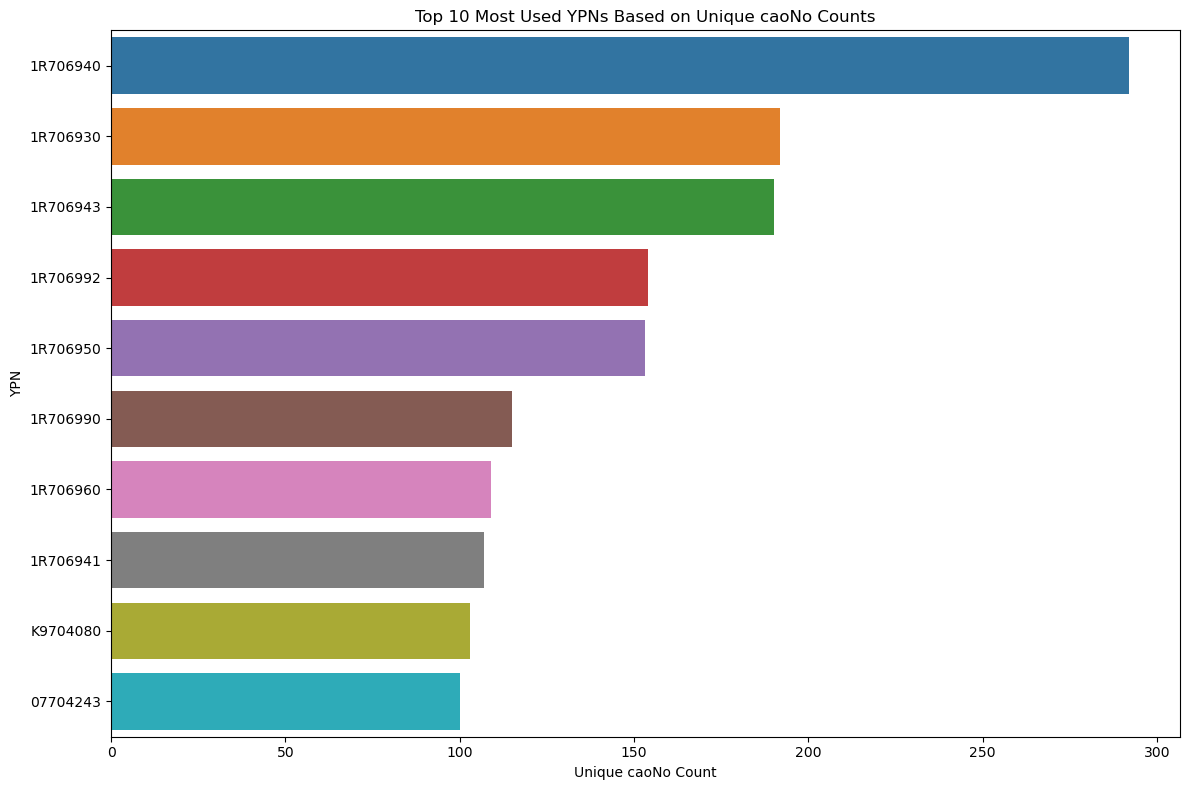

In [54]:
query = """
SELECT
    YPN,
    COUNT(DISTINCT caono) AS DistinctCaoNoCount
FROM (
    SELECT
        YPN1 AS YPN,
        caono
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1 AND
        ProdProgress = 500 AND
        YPN1 IS NOT NULL AND YPN1 <> ''
        and ActionStatus='Finished/Cancelled'

    UNION ALL
    SELECT
        YPN2,
        caono
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1 AND
        ProdProgress = 500 AND
        YPN2 IS NOT NULL AND YPN2 <> ''
        and ActionStatus='Finished/Cancelled'

) AS Subquery
WHERE
    YPN IS NOT NULL AND YPN <> ''
GROUP BY
    YPN
ORDER BY
    DistinctCaoNoCount DESC;
"""


try:
    cursor.execute(query)
    data = cursor.fetchall()
except Exception as e:
    print(f"Error executing query: {e}")

columns = ['YPN', 'DistinctCaoNoCount']

df = pd.DataFrame(data, columns=columns)

top_n = 10  # Adjust as needed for top N YPNs
plt.figure(figsize=(12, 8))
sns.barplot(x='DistinctCaoNoCount', y='YPN', data=df.head(top_n), orient='h')
plt.title(f'Top {top_n} Most Used YPNs Based on Unique caoNo Counts')
plt.xlabel('Unique caoNo Count')
plt.ylabel('YPN')
plt.tight_layout()
plt.show()

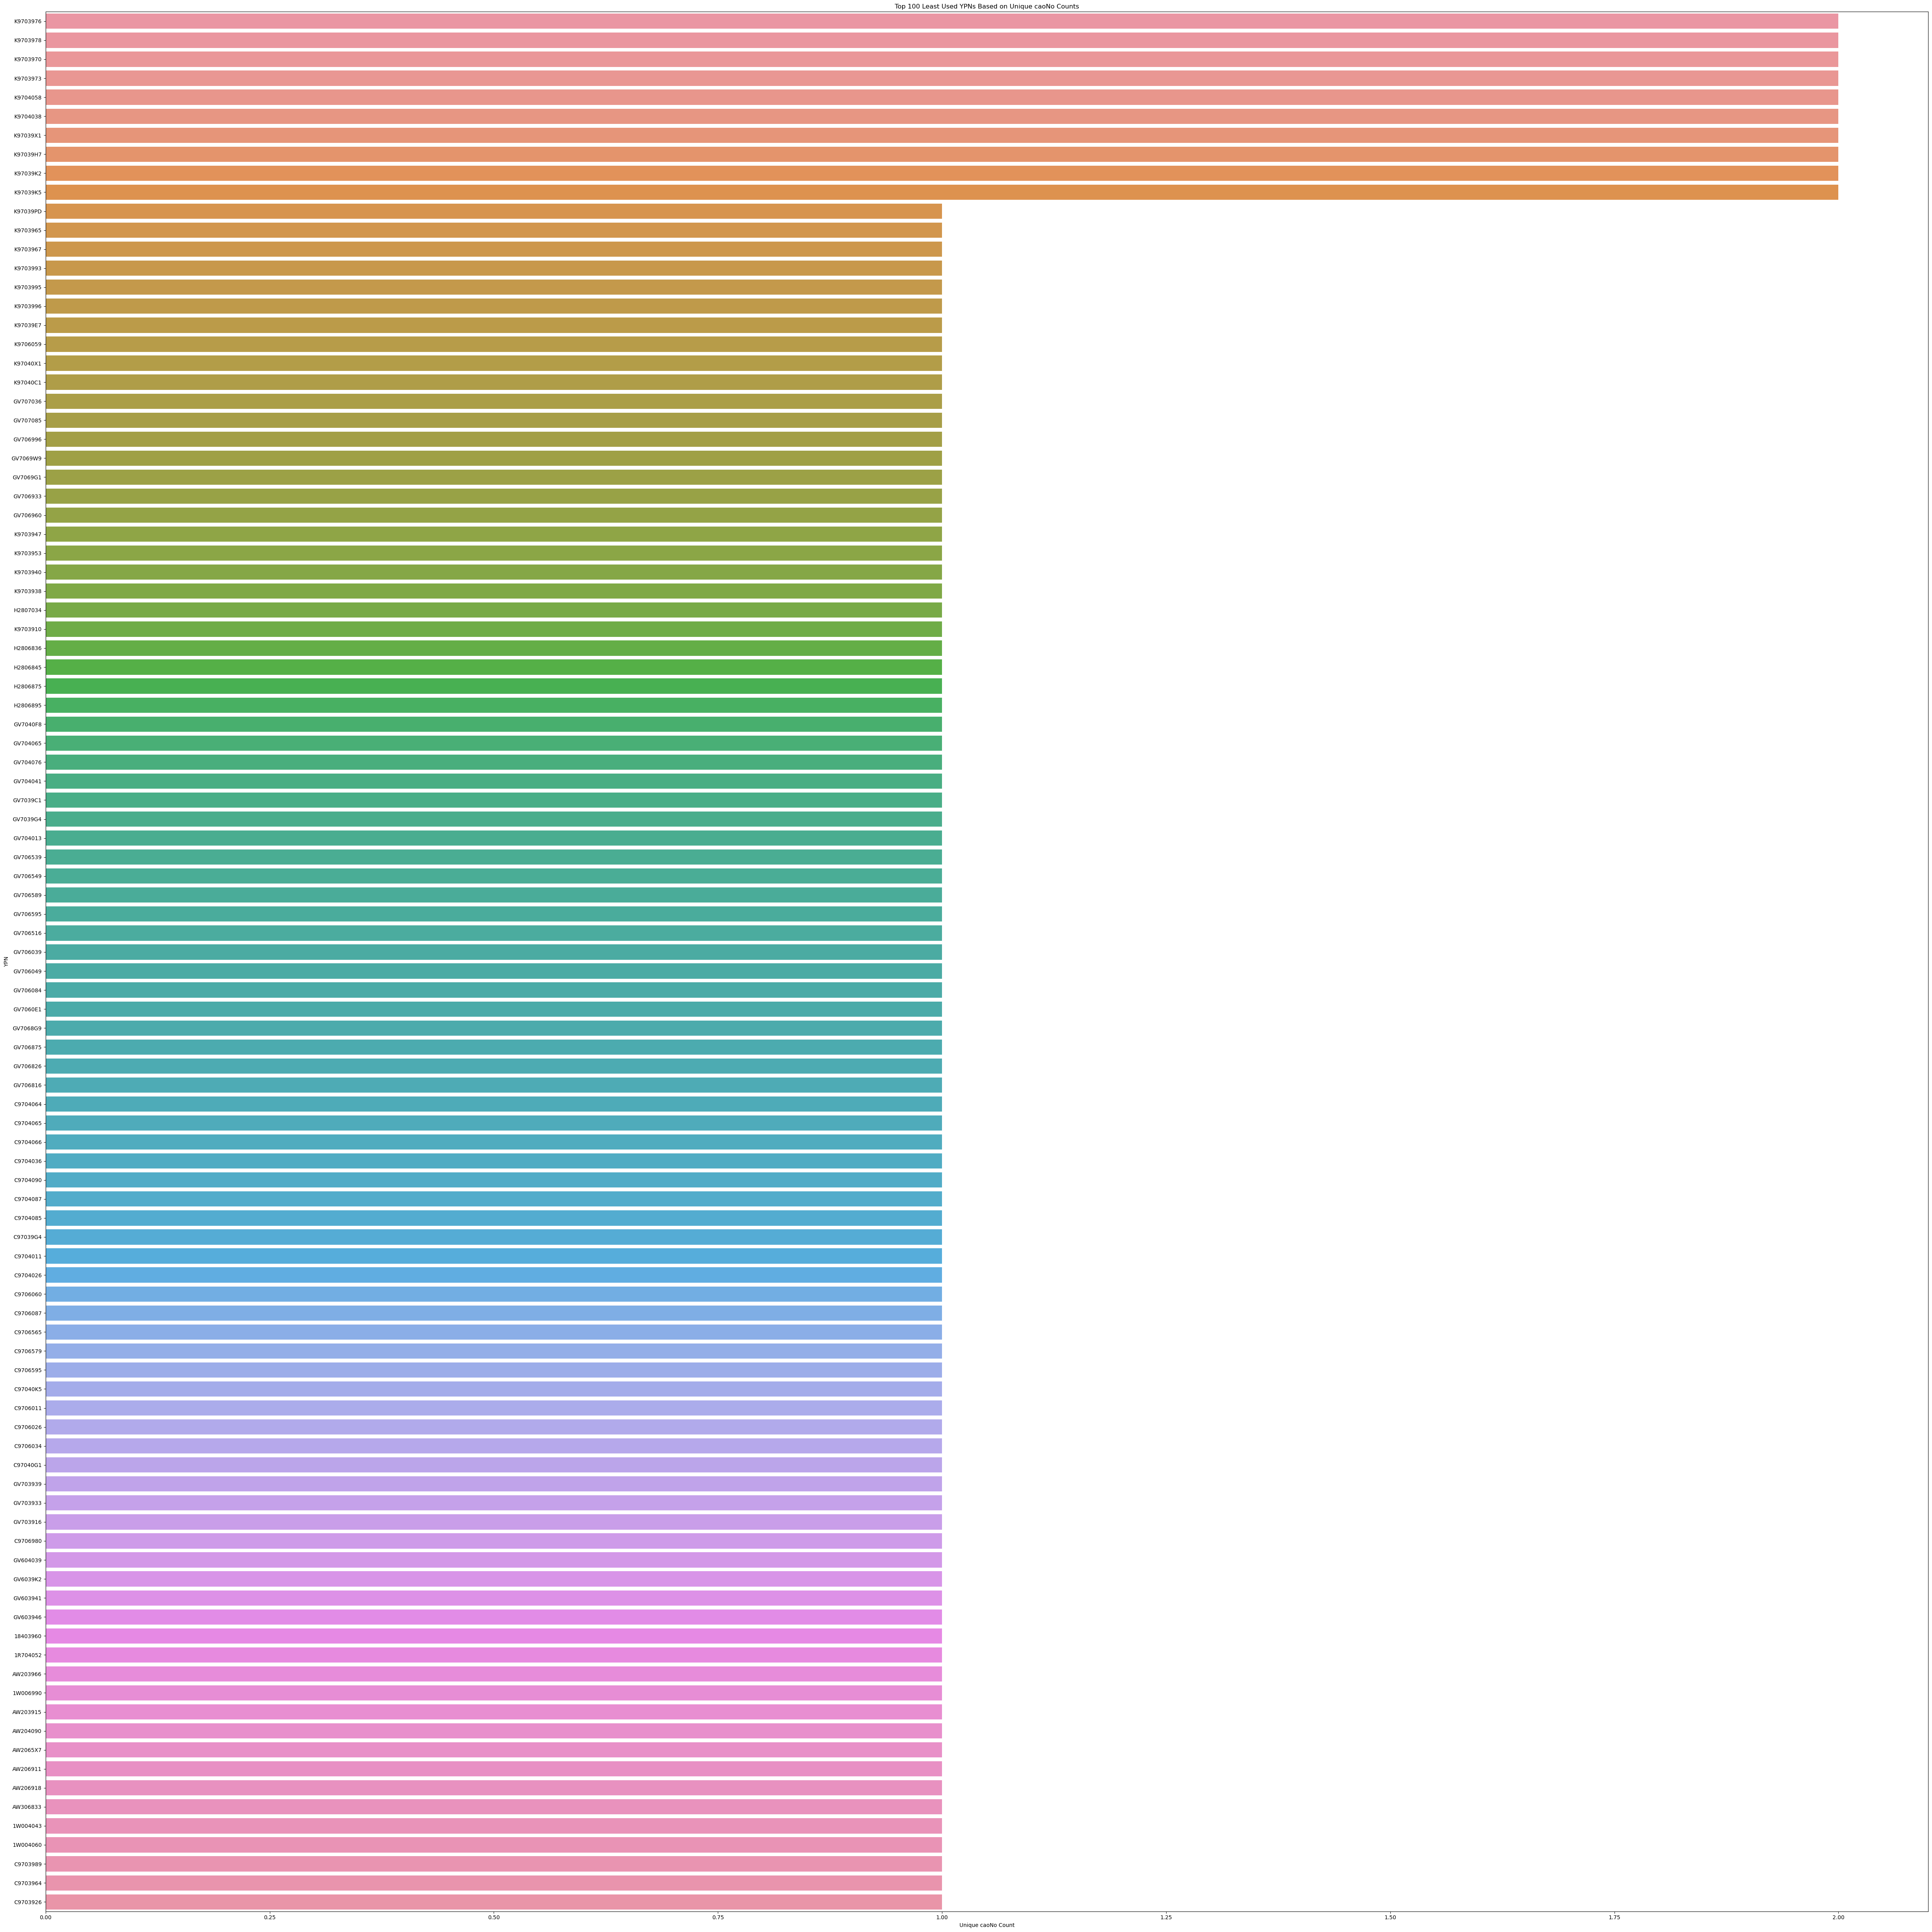

In [55]:
least_n = 100  
plt.figure(figsize=(50, 50))
sns.barplot(x='DistinctCaoNoCount', y='YPN', data=df.tail(least_n), orient='h')
plt.title(f'Top {least_n} Least Used YPNs Based on Unique caoNo Counts')
plt.xlabel('Unique caoNo Count')
plt.ylabel('YPN')
plt.tight_layout()
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/3551350174.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top = pd.read_sql(query_top, con)


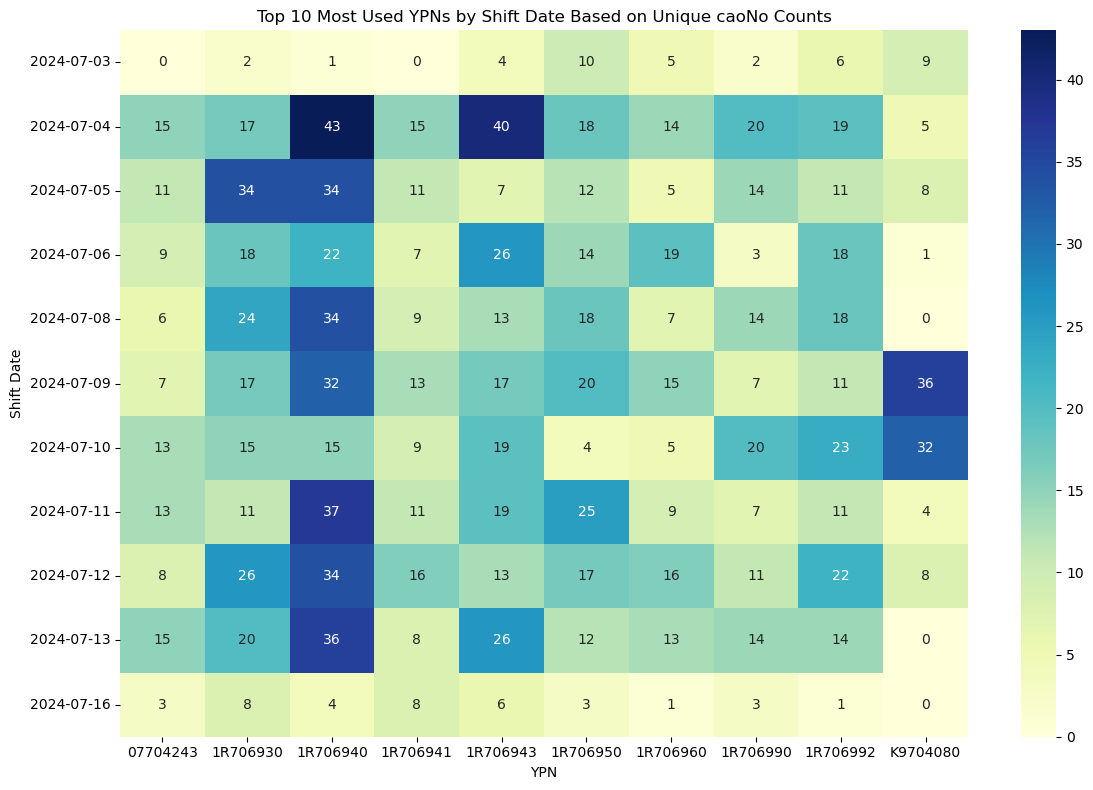

In [51]:
query_top = """
SELECT
    ShiftDate,
    YPN,
    COUNT(DISTINCT caono) AS DistinctCaoNoCount
FROM (
    SELECT
        ShiftDate,
        YPN1 AS YPN,
        caono
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1 AND
        ProdProgress = 500 AND
        YPN1 IS NOT NULL AND YPN1 <> ''
        and ActionStatus='Finished/Cancelled'

    UNION ALL
    SELECT
        ShiftDate,
        YPN2,
        caono
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1 AND
        ProdProgress = 500 AND
        YPN2 IS NOT NULL AND YPN2 <> ''
        and ActionStatus='Finished/Cancelled'
) AS Subquery
WHERE
    YPN IS NOT NULL AND YPN <> ''
GROUP BY
    ShiftDate,
    YPN
ORDER BY
    ShiftDate,
    DistinctCaoNoCount DESC;
"""

df_top = pd.read_sql(query_top, con)
# Get the top 10 YPNs based on unique caoNo counts
top_n = 10
top_ypns = df_top.groupby('YPN')['DistinctCaoNoCount'].sum().nlargest(top_n).index.tolist()

# Filter the DataFrame for the top 10 YPNs
df_top = df_top[df_top['YPN'].isin(top_ypns)]

pivot_df = pd.pivot_table(df_top, values='DistinctCaoNoCount', index='ShiftDate', columns='YPN', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Top 10 Most Used YPNs by Shift Date Based on Unique caoNo Counts')
plt.xlabel('YPN')
plt.ylabel('Shift Date')
plt.tight_layout()
plt.show()

In [85]:
query_heatmap = """
 SELECT
    Machines_Id,
    ShiftDate,
    COUNT(DISTINCT caono) AS DistinctCaoNoCount
FROM
    YMT_2
WHERE
    Seq = 1 AND
    isFilAvail = 1 AND
    ProdProgress = 500
    and ActionStatus='Finished/Cancelled'

GROUP BY
    Machines_Id,
    ShiftDate
ORDER BY
    ShiftDate,
    Machines_Id;
"""

df_heatmap = pd.read_sql(query_heatmap, con)

pivot_df = df_heatmap.pivot(index='ShiftDate', columns='Machines_Id', values='DistinctCaoNoCount').fillna(0)

plt.figure(figsize=(100, 50))
sns.heatmap(pivot_df, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Machine Usage by Shift Date Based on Unique caoNo Counts')
plt.xlabel('Machines_Id')
plt.ylabel('Shift Date')
plt.tight_layout()
#plt.savefig('heatmapYMT.png')  

plt.figure(figsize=(20, 20))
ax = df.plot(kind='bar', x='machines_Id', y='ShiftDate',width=0.5, rot=0)
ax.set_xlabel('Machine ID')
ax.set_ylabel('Average Time to Complete (seconds)')
ax.set_title('Average Time to Complete by Machine')


KeyError: 'ShiftDate'

<Figure size 10000x5000 with 0 Axes>

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/2184488797.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top10 = pd.read_sql(query_filtered_top10_machines, con)


<Figure size 1500x1000 with 0 Axes>

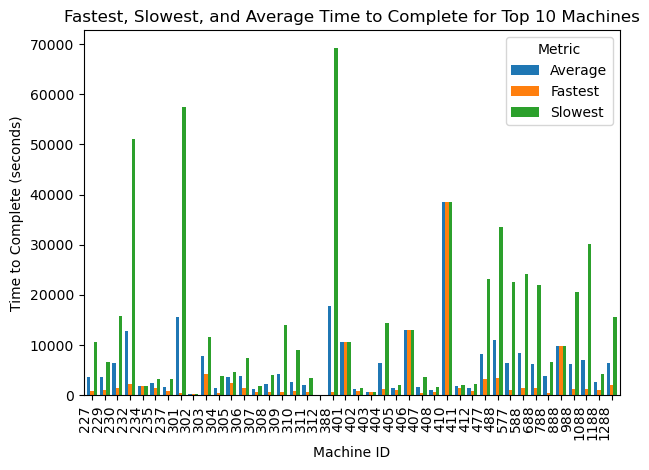

In [52]:
query_filtered_top10_machines = """
WITH RankedMachines AS (
    SELECT
        machines_id,
        SNumber,
        caono,
        CONVERT(varchar(8), DATEADD(second, DATEDIFF(second, MIN(ActionStatusDate), MAX(CASE WHEN Seq = 1 AND isFilAvail = 1 AND ProdProgress = 500 and ActionStatus='Finished/Cancelled'
 THEN ActionStatusDate END)), 0), 108) AS TimeToComplete,
        ROW_NUMBER() OVER (PARTITION BY machines_id ORDER BY MIN(ActionStatusDate)) AS RowNum
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1
    GROUP BY
        SNumber,
        caono,
        machines_id
    HAVING
        MAX(CASE WHEN Seq = 1 AND isFilAvail = 1 AND ProdProgress = 500 and ActionStatus='Finished/Cancelled'
 THEN ActionStatusDate END) IS NOT NULL
)
SELECT
    machines_id,
    SNumber,
    caono,
    TimeToComplete
FROM
    RankedMachines
WHERE
    TimeToComplete <> '00:00:00' AND RowNum <= 10
ORDER BY
    TimeToComplete,
    machines_id;
"""
df_top10 = pd.read_sql(query_filtered_top10_machines, con)

df_top10['TimeToComplete'] = pd.to_timedelta(df_top10['TimeToComplete'])

summary = df_top10.groupby('machines_id').agg(
    Fastest=('TimeToComplete', 'min'),
    Slowest=('TimeToComplete', 'max'),
    Average=('TimeToComplete', 'mean')
).reset_index()

summary['Fastest'] = summary['Fastest'].dt.total_seconds()
summary['Slowest'] = summary['Slowest'].dt.total_seconds()
summary['Average'] = summary['Average'].dt.total_seconds()

summary_melted = summary.melt(id_vars='machines_id', value_vars=['Fastest', 'Slowest', 'Average'], var_name='Metric', value_name='TimeToComplete')

plt.figure(figsize=(15, 10))
ax = summary_melted.pivot(index='machines_id', columns='Metric', values='TimeToComplete').plot(kind='bar', width=0.8)

ax.set_xlabel('Machine ID')
ax.set_ylabel('Time to Complete (seconds)')
ax.set_title('Fastest, Slowest, and Average Time to Complete for Top 10 Machines')

plt.xticks(rotation=90, ha='right')

plt.tight_layout()

plt.show()


/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/2336070994.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


<Figure size 2000x2000 with 0 Axes>

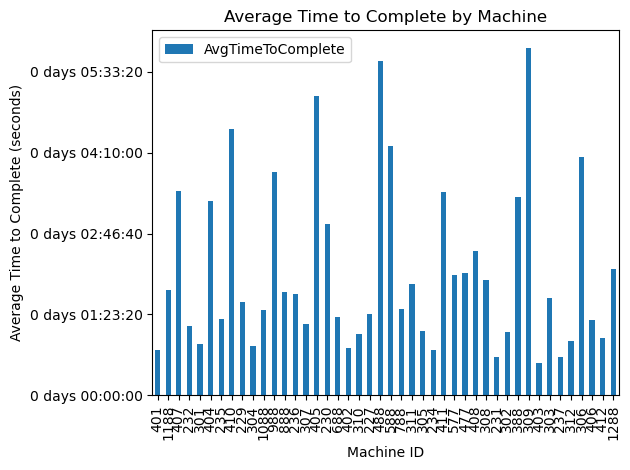

In [53]:
query = """
WITH TimeInSeconds AS (
    SELECT
        machines_Id,
        SNumber,
        caono,
        DATEDIFF(second, MIN(ActionStatusDate), MAX(CASE WHEN Seq = 1 AND isFilAvail = 1 AND ProdProgress = 500 and ActionStatus='Finished/Cancelled'
 THEN ActionStatusDate END)) AS TimeToComplete
    FROM
        YMT_2
    WHERE
        Seq = 1 AND
        isFilAvail = 1
    GROUP BY
        SNumber,
        caono,
        machines_Id
    HAVING
        MAX(CASE WHEN Seq = 1 AND isFilAvail = 1 AND ProdProgress = 500  and ActionStatus='Finished/Cancelled'
 THEN ActionStatusDate END) IS NOT NULL
)
SELECT
    machines_Id,
    CONVERT(varchar(8), DATEADD(second, AVG(TimeToComplete), 0), 108) AS AvgTimeToComplete
FROM
    TimeInSeconds
WHERE
    TimeToComplete > 0
GROUP BY
    machines_Id
"""
df = pd.read_sql(query, con)

# Convert 'AvgTimeToComplete' to seconds
df['AvgTimeToComplete'] = df['AvgTimeToComplete'].apply(lambda x: pd.Timedelta(x).total_seconds())

# Plot
plt.figure(figsize=(20, 20))
ax = df.plot(kind='bar', x='machines_Id', y='AvgTimeToComplete',width=0.5, rot=0)
ax.set_xlabel('Machine ID')
ax.set_ylabel('Average Time to Complete (seconds)')
ax.set_title('Average Time to Complete by Machine')

# Format y-axis labels
def format_seconds(x, pos):
    return str(pd.Timedelta(seconds=int(x)))
ax.yaxis.set_major_formatter(FuncFormatter(format_seconds))

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/3781460506.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


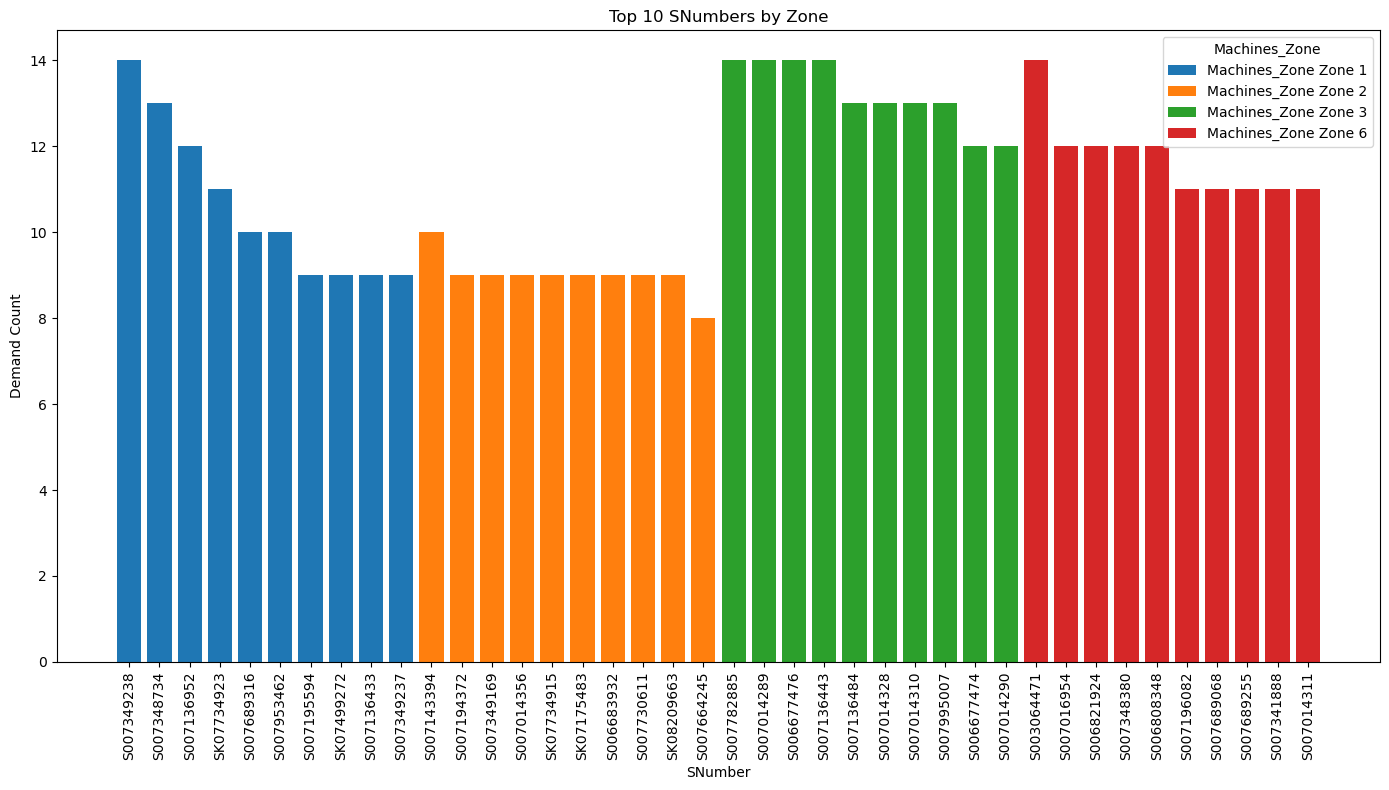

In [110]:
query = """
WITH RankedSNumbers AS (
    SELECT
        Machines_Zone,
        SNumber,
        COUNT(DISTINCT caono) AS demand_count,
        ROW_NUMBER() OVER (PARTITION BY Machines_Zone ORDER BY COUNT(DISTINCT caono) DESC) AS rn
    FROM
        YMT_2
    GROUP BY
        Machines_Zone,
        SNumber
)
SELECT
    Machines_Zone,
    SNumber,
    demand_count
FROM
    RankedSNumbers
WHERE
    rn <= 10
ORDER BY
    Machines_Zone, demand_count DESC;
"""
df = pd.read_sql(query, con)


# Set the figure size
plt.figure(figsize=(14, 8))

# Plot the data
zones = df['Machines_Zone'].unique()
for zone in zones:
    subset = df[df['Machines_Zone'] == zone]
    plt.bar(subset['SNumber'], subset['demand_count'], label=f'Machines_Zone {zone}')

# Set axis labels and title
plt.xlabel('SNumber')
plt.ylabel('Demand Count')
plt.title('Top 10 SNumbers by Zone')
plt.legend(title='Machines_Zone')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/633765434.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


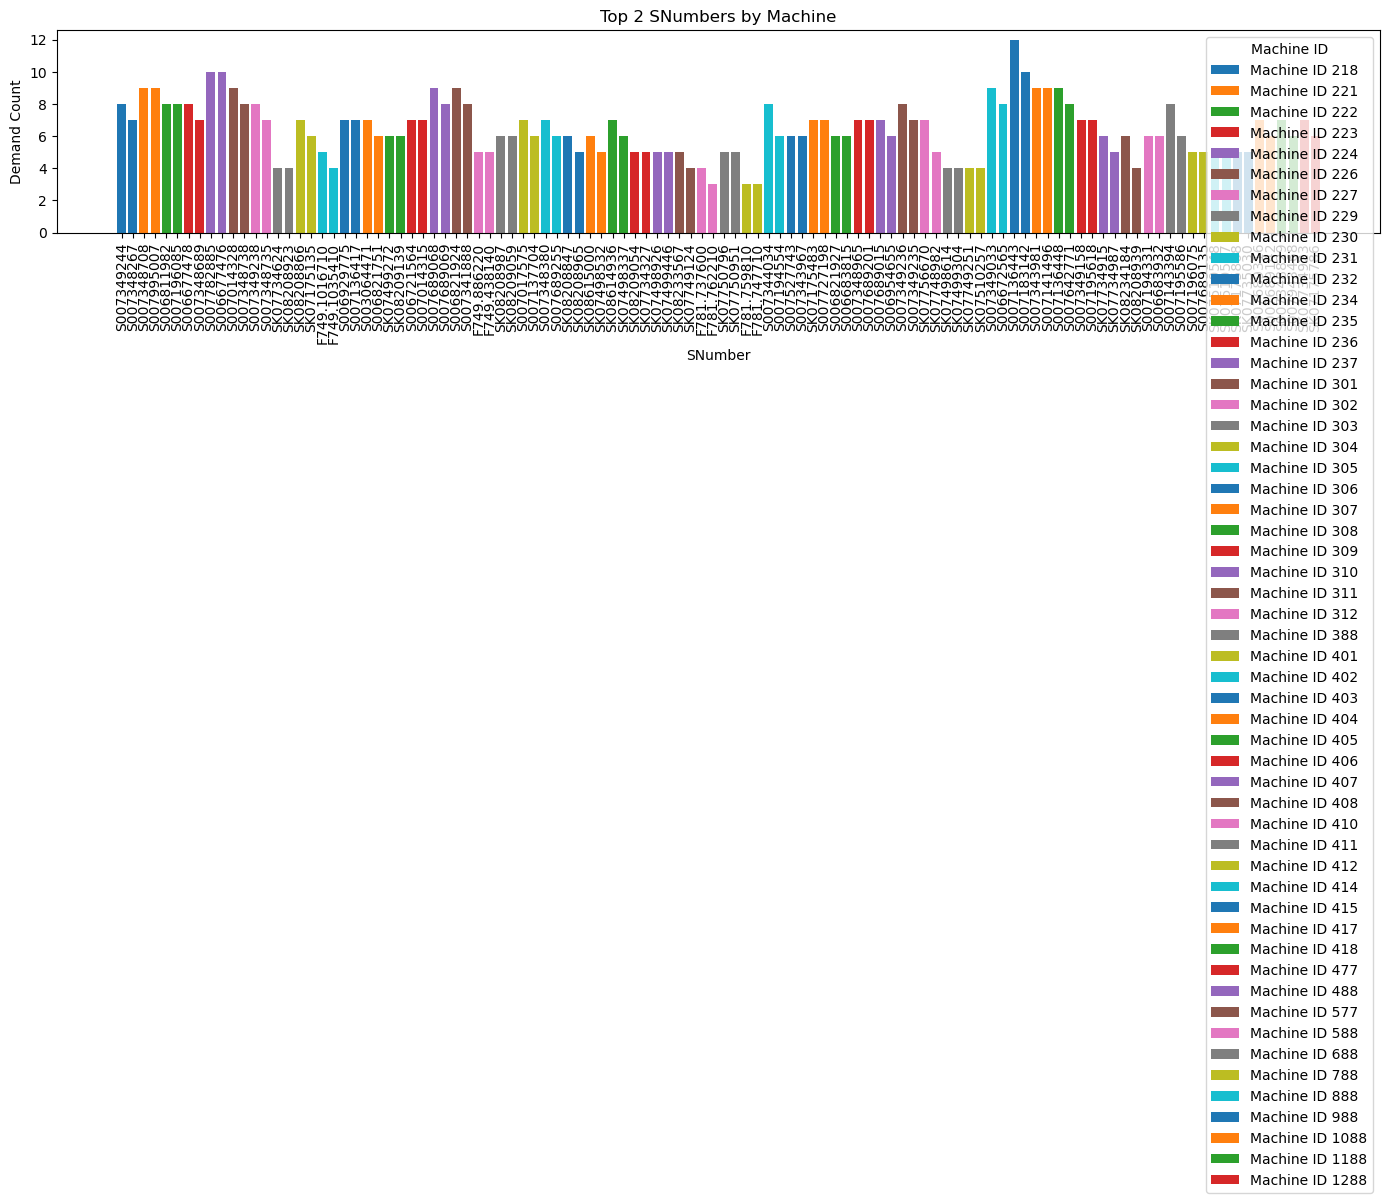

In [71]:
# Execute query and load data into a DataFrame
query = """
WITH RankedSNumbers AS (
    SELECT
        machines_id,
        SNumber,
        COUNT(DISTINCT caono) AS demand_count,
        ROW_NUMBER() OVER (PARTITION BY machines_id ORDER BY COUNT(DISTINCT caono) DESC) AS rn
    FROM
        YMT_2
    GROUP BY
        machines_id,
        SNumber
)
SELECT
    machines_id,
    SNumber,
    demand_count
FROM
    RankedSNumbers
WHERE
    rn <= 2
ORDER BY
    machines_id, demand_count DESC;
"""
df = pd.read_sql(query, con)



# Set the figure size
plt.figure(figsize=(14, 8))

# Plot the data
machines = df['machines_id'].unique()
for machine in machines:
    subset = df[df['machines_id'] == machine]
    plt.bar(subset['SNumber'], subset['demand_count'], label=f'Machine ID {machine}')

# Set axis labels and title
plt.xlabel('SNumber')
plt.ylabel('Demand Count')
plt.title('Top 2 SNumbers by Machine')
plt.legend(title='Machine ID')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/4179219912.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


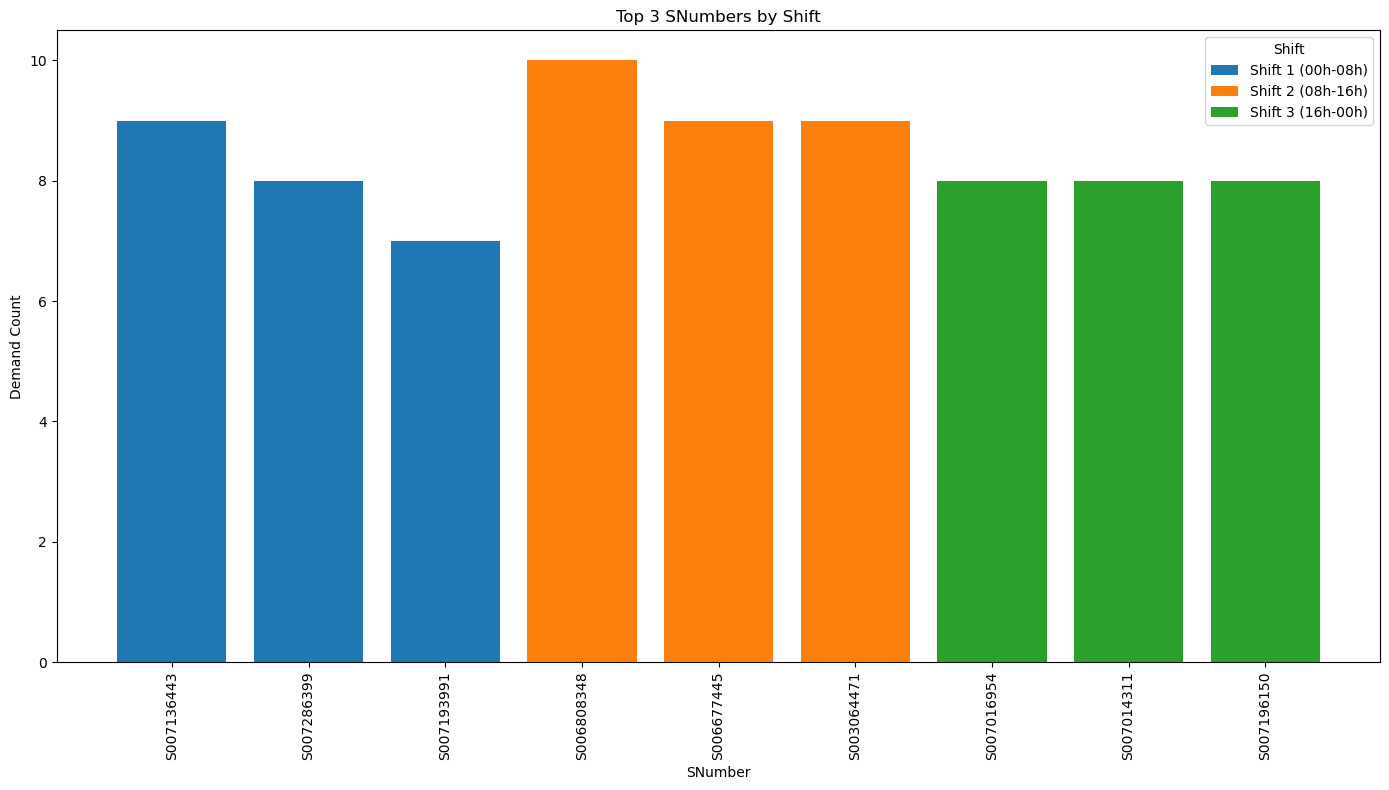

In [111]:
query = """
WITH RankedSNumbers AS (
    SELECT
        Shift,
        SNumber,
        COUNT(DISTINCT caono) AS demand_count,
        ROW_NUMBER() OVER (PARTITION BY Shift ORDER BY COUNT(DISTINCT caono) DESC) AS rn
    FROM
        YMT_2
    GROUP BY
        Shift,
        SNumber
)
SELECT
    Shift,
    SNumber,
    demand_count
FROM
    RankedSNumbers
WHERE
    rn <= 3
ORDER BY
    Shift, demand_count DESC;
"""
df = pd.read_sql(query, con)



# Set the figure size
plt.figure(figsize=(14, 8))

# Plot the data
shifts = df['Shift'].unique()
for shift in shifts:
    subset = df[df['Shift'] == shift]
    plt.bar(subset['SNumber'], subset['demand_count'], label=f'Shift {shift}')

# Set axis labels and title
plt.xlabel('SNumber')
plt.ylabel('Demand Count')
plt.title('Top 3 SNumbers by Shift')
plt.legend(title='Shift')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/2387689396.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


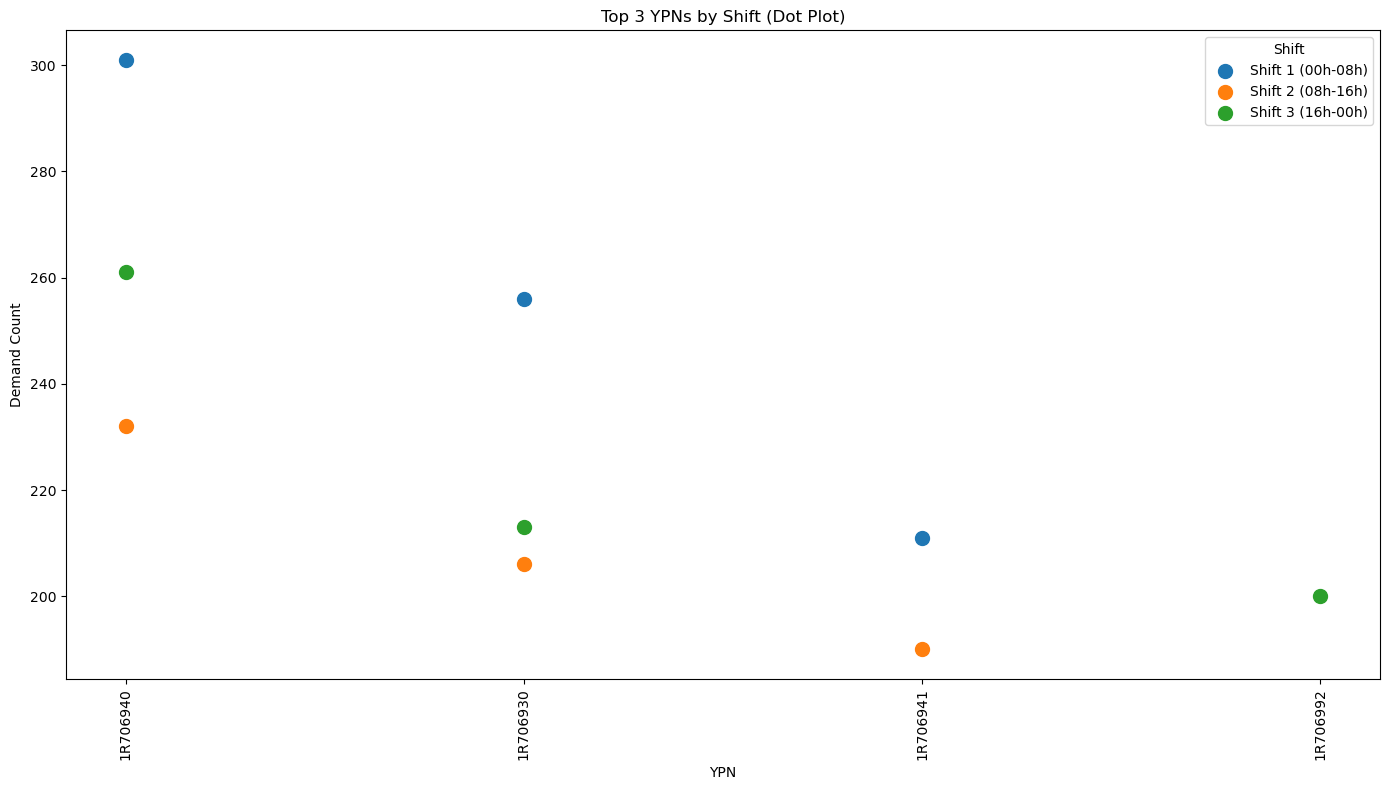

In [74]:
query = """
WITH MovementSummary AS (
    SELECT
        Shift,
        YPN,
        COUNT(DISTINCT MvmntID) AS demand_count,
        ROW_NUMBER() OVER (PARTITION BY Shift ORDER BY COUNT(DISTINCT MvmntID) DESC) AS rn
    FROM
        StockMouvementsB
    GROUP BY
        Shift,
        YPN
)
SELECT
    Shift,
    YPN,
    demand_count
FROM
    MovementSummary
WHERE
    rn <= 3
ORDER BY
    Shift, demand_count DESC;
"""

df = pd.read_sql(query, con)
plt.figure(figsize=(14, 8))

for shift in df['Shift'].unique():
    subset = df[df['Shift'] == shift]
    plt.scatter(subset['YPN'], subset['demand_count'], label=f'Shift {shift}', s=100)

plt.xlabel('YPN')
plt.ylabel('Demand Count')
plt.title('Top 3 YPNs by Shift (Dot Plot)')
plt.legend(title='Shift')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/2807277221.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


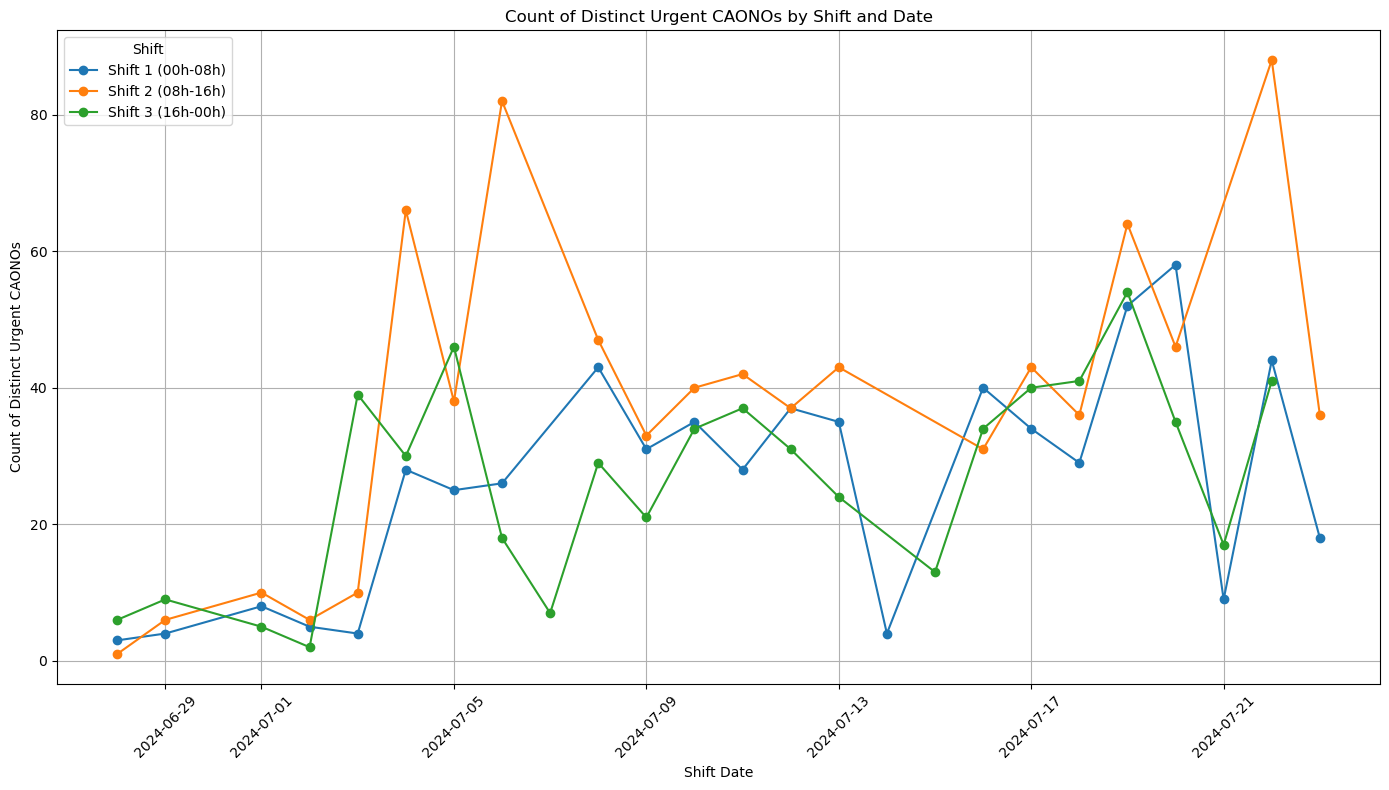

In [83]:
query = """
SELECT
    Shift,
    ShiftDate,
    COUNT(DISTINCT CAONO) AS UrgentCAONOs
FROM
    YMT_3
WHERE
    Urgent = 1
GROUP BY
    Shift,
    ShiftDate
ORDER BY
    ShiftDate, Shift;
"""

# Execute the query and load data into DataFrame
df = pd.read_sql(query, con)

# Convert ShiftDate to datetime for plotting
df['ShiftDate'] = pd.to_datetime(df['ShiftDate'])

# Plot the data
plt.figure(figsize=(14, 8))
for shift in df['Shift'].unique():
    subset = df[df['Shift'] == shift]
    plt.plot(subset['ShiftDate'], subset['UrgentCAONOs'], marker='o', label=f'Shift {shift}')

plt.xlabel('Shift Date')
plt.ylabel('Count of Distinct Urgent CAONOs')
plt.title('Count of Distinct Urgent CAONOs by Shift and Date')
plt.legend(title='Shift')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/460362153.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con)


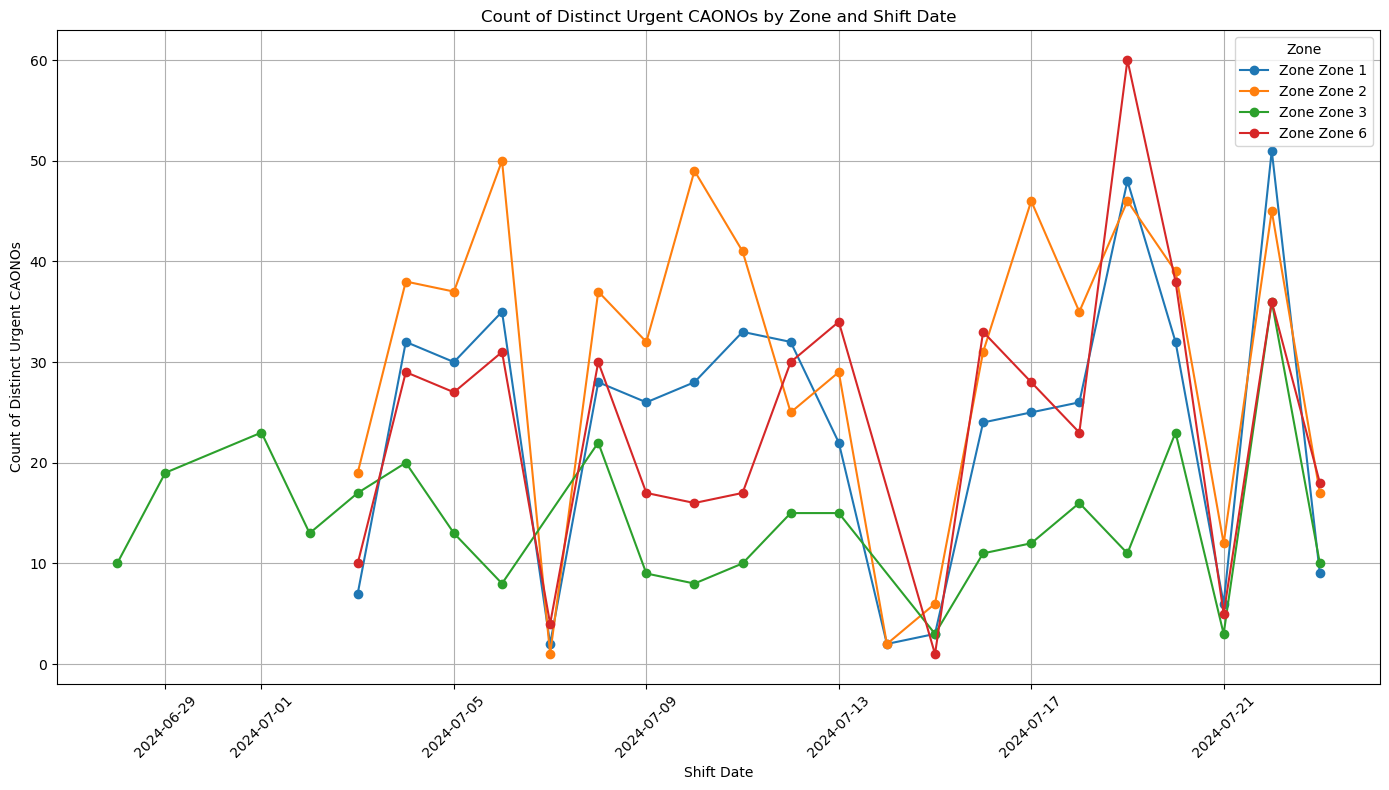

In [86]:
query = """
SELECT
    Machines_Zone,
    ShiftDate,
    COUNT(DISTINCT CAONO) AS UrgentCAONOs
FROM
    YMT_3
WHERE
    Urgent = 1
    
GROUP BY
    Machines_Zone,
    ShiftDate
ORDER BY
    Machines_Zone, ShiftDate;
"""

# Execute the query and load data into DataFrame
df = pd.read_sql(query, con)

# Convert ShiftDate to datetime for plotting
df['ShiftDate'] = pd.to_datetime(df['ShiftDate'])

# Plot the data
plt.figure(figsize=(14, 8))
for zone in df['Machines_Zone'].unique():
    subset = df[df['Machines_Zone'] == zone]
    plt.plot(subset['ShiftDate'], subset['UrgentCAONOs'], marker='o', label=f'Zone {zone}')

plt.xlabel('Shift Date')
plt.ylabel('Count of Distinct Urgent CAONOs')
plt.title('Count of Distinct Urgent CAONOs by Zone and Shift Date')
plt.legend(title='Zone')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


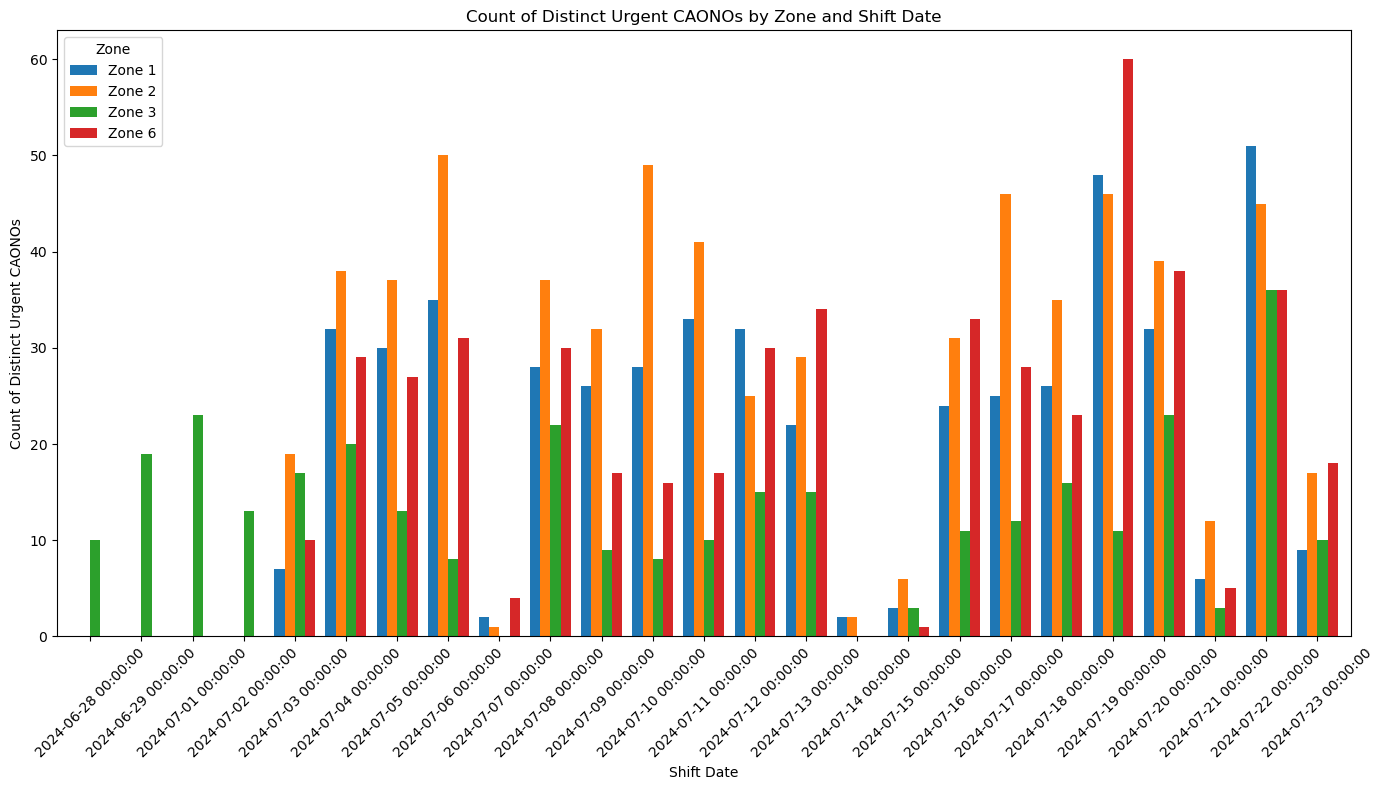

In [87]:
pivot_df = df.pivot_table(index='ShiftDate', columns='Machines_Zone', values='UrgentCAONOs', fill_value=0)

# Plot the data
pivot_df.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.xlabel('Shift Date')
plt.ylabel('Count of Distinct Urgent CAONOs')
plt.title('Count of Distinct Urgent CAONOs by Zone and Shift Date')
plt.legend(title='Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/1679086913.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


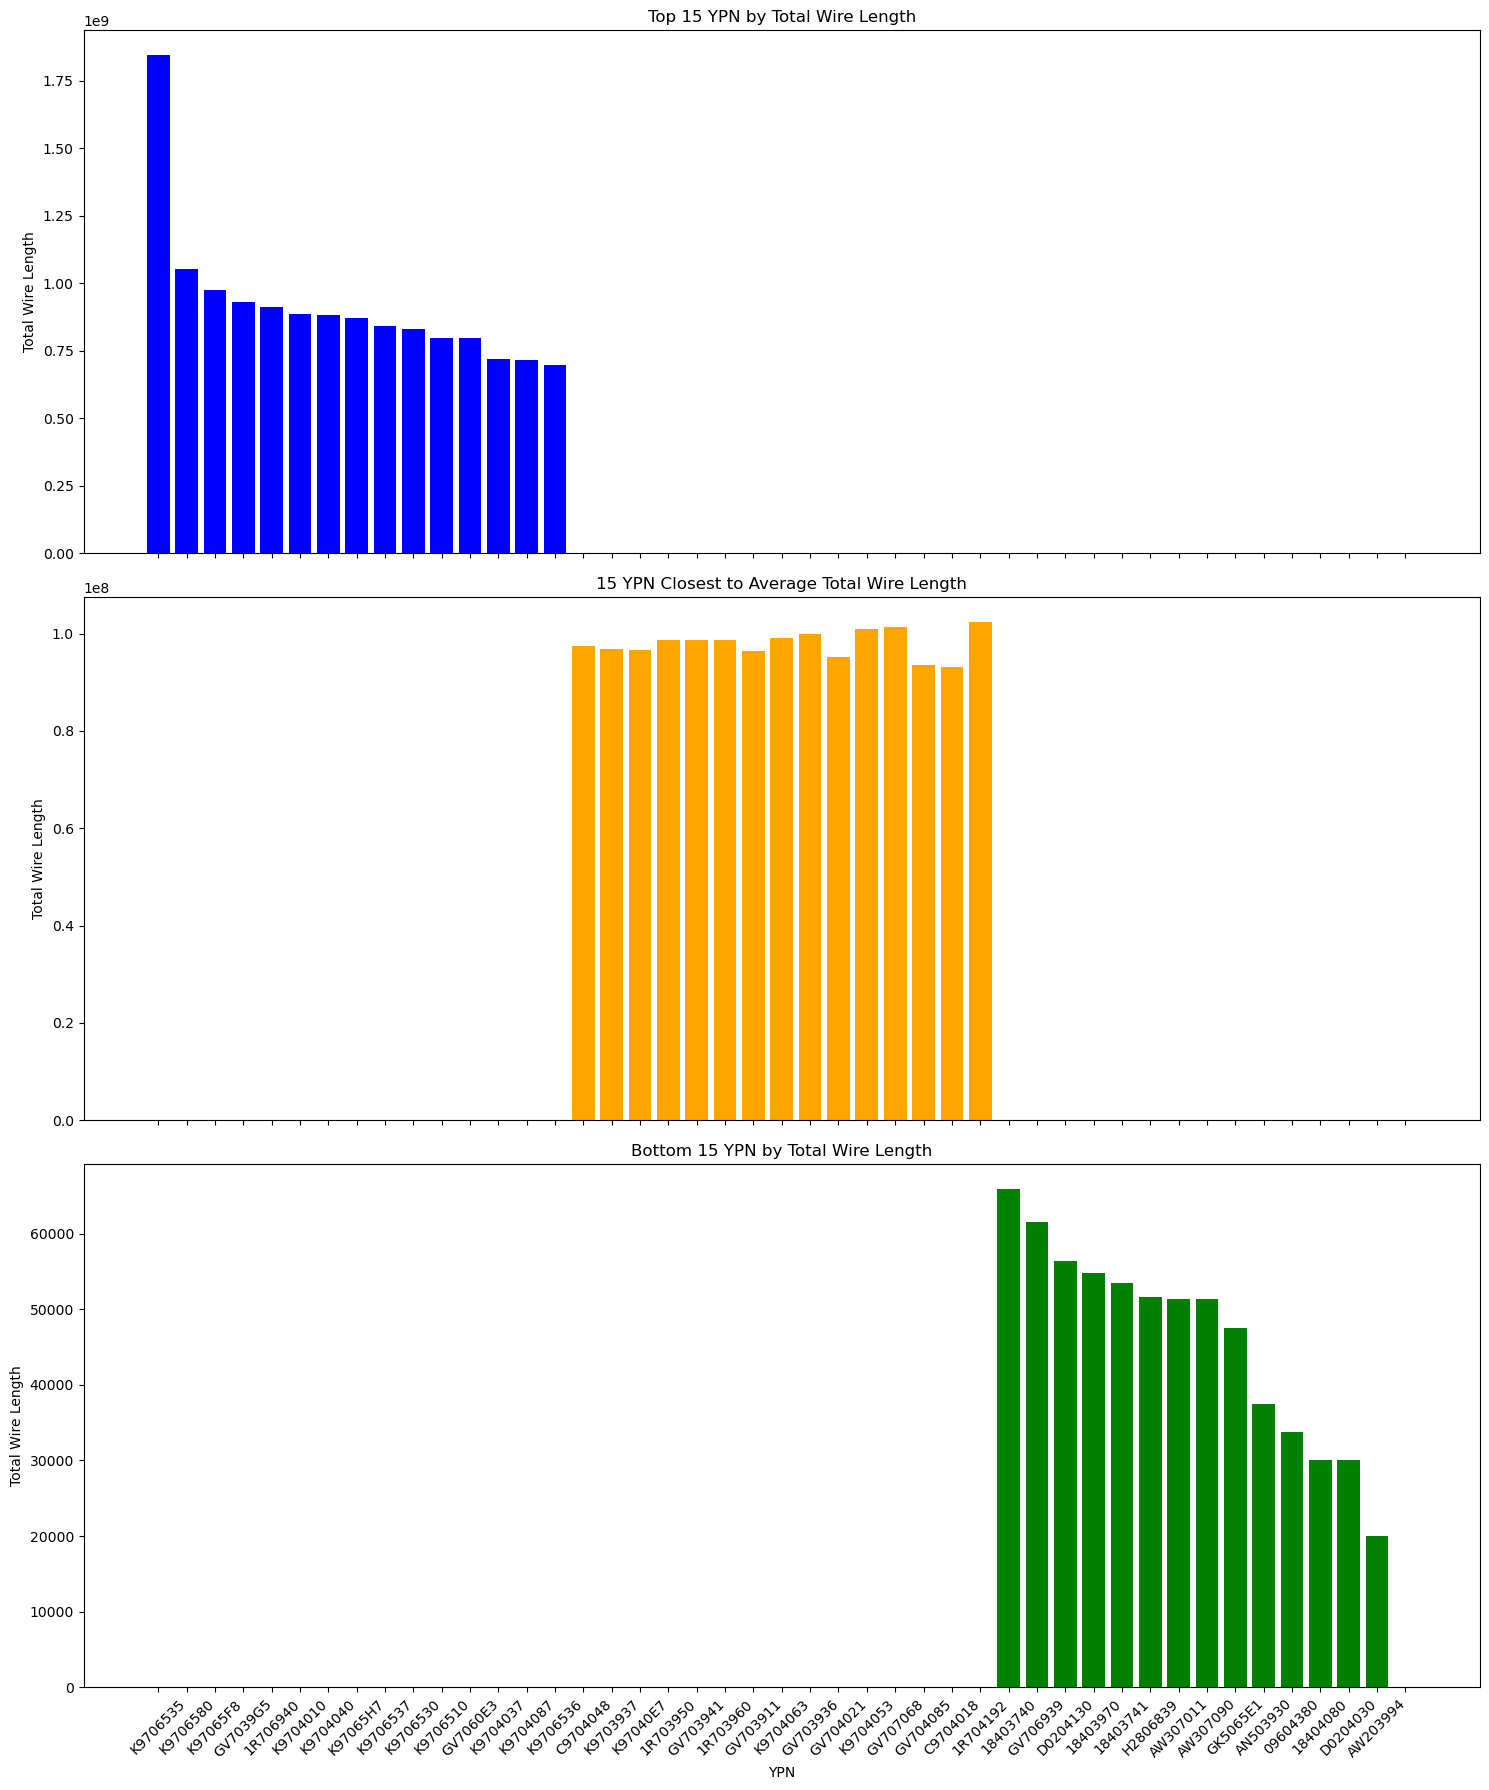

In [106]:
query = """
WITH CombinedLengths AS (
    SELECT
        T.YPN1 AS YPN,
        SUM(T.Quantity * B1.WireLeftLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B1 ON T.SNumber = B1.CutleadNo AND T.YPN1 = B1.WireLeftIdentifier
    GROUP BY
        T.YPN1

    UNION ALL

    SELECT
        T.YPN2 AS YPN,
        SUM(T.Quantity * B2.WireRightLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B2 ON T.SNumber = B2.CutleadNo AND T.YPN2 = B2.WireRightIdentifier
    GROUP BY
        T.YPN2
),
AggregatedLengths AS (
    SELECT
        YPN,
        SUM(TotalLength) AS TotalWireLength
    FROM
        CombinedLengths
    GROUP BY
        YPN
)

SELECT
    YPN,
    TotalWireLength
FROM
    AggregatedLengths
ORDER BY
    TotalWireLength DESC;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql_query(query, con)



# Top 15 YPN
top15 = df.head(15)

# Bottom 15 YPN
bottom15 = df.tail(15)

# Calculate average TotalWireLength
average_length = df['TotalWireLength'].mean()

# 15 YPN closest to average TotalWireLength
df['DistanceToAvg'] = abs(df['TotalWireLength'] - average_length)
average15 = df.nsmallest(15, 'DistanceToAvg')

# Plotting the results
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# Top 15
axes[0].bar(top15['YPN'], top15['TotalWireLength'], color='blue')
axes[0].set_title('Top 15 YPN by Total Wire Length')
axes[0].set_ylabel('Total Wire Length')
axes[0].tick_params(axis='x', rotation=45)
# Average 15
axes[1].bar(average15['YPN'], average15['TotalWireLength'], color='orange')
axes[1].set_title('15 YPN Closest to Average Total Wire Length')
axes[1].set_ylabel('Total Wire Length')
axes[1].tick_params(axis='x', rotation=45)
# Bottom 15
axes[2].bar(bottom15['YPN'], bottom15['TotalWireLength'], color='green')
axes[2].set_title('Bottom 15 YPN by Total Wire Length')
axes[2].set_ylabel('Total Wire Length')
axes[2].tick_params(axis='x', rotation=45)

plt.xlabel('YPN')
plt.tight_layout()

plt.show()

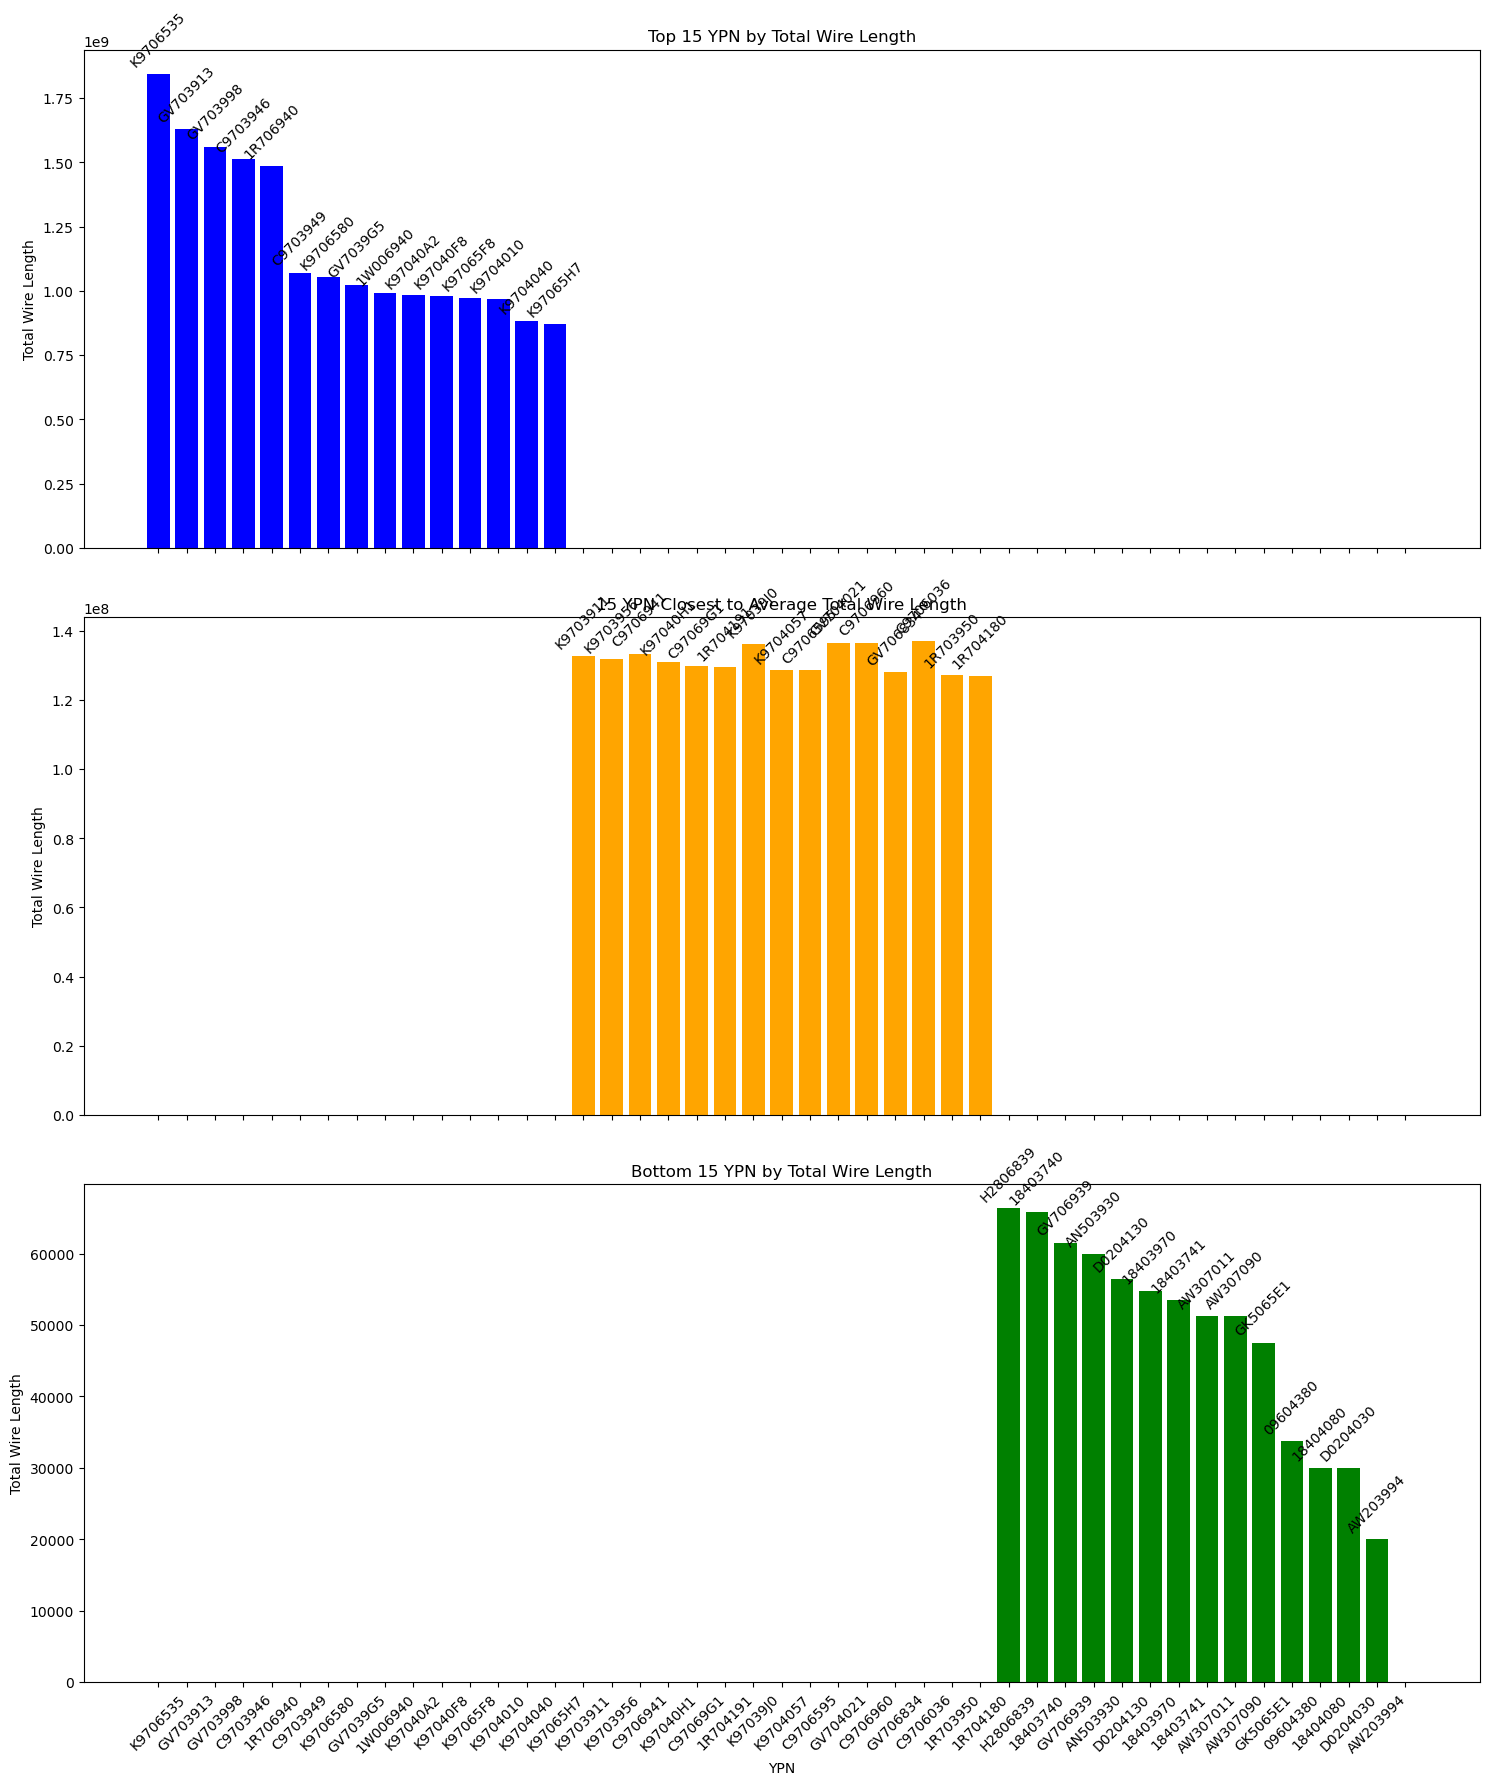

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already executed the query and loaded the results into a DataFrame
# df = pd.read_sql_query(query, con)

# Top 15 YPN
top15 = df.head(15)

# Bottom 15 YPN
bottom15 = df.tail(15)

# Calculate average TotalWireLength
average_length = df['TotalWireLength'].mean()

# 15 YPN closest to average TotalWireLength
df['DistanceToAvg'] = abs(df['TotalWireLength'] - average_length)
average15 = df.nsmallest(15, 'DistanceToAvg')

# Plotting the results
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# Top 15
bars1 = axes[0].bar(top15['YPN'], top15['TotalWireLength'], color='blue')
axes[0].bar_label(bars1, labels=top15['YPN'], rotation=45, padding=3)
axes[0].set_title('Top 15 YPN by Total Wire Length')
axes[0].set_ylabel('Total Wire Length')
axes[0].tick_params(axis='x', rotation=45)

# Average 15
bars2 = axes[1].bar(average15['YPN'], average15['TotalWireLength'], color='orange')
axes[1].bar_label(bars2, labels=average15['YPN'], rotation=45, padding=3)
axes[1].set_title('15 YPN Closest to Average Total Wire Length')
axes[1].set_ylabel('Total Wire Length')
axes[1].tick_params(axis='x', rotation=45)

# Bottom 15
bars3 = axes[2].bar(bottom15['YPN'], bottom15['TotalWireLength'], color='green')
axes[2].bar_label(bars3, labels=bottom15['YPN'], rotation=45, padding=3)
axes[2].set_title('Bottom 15 YPN by Total Wire Length')
axes[2].set_ylabel('Total Wire Length')
axes[2].tick_params(axis='x', rotation=45)

plt.xlabel('YPN')
plt.tight_layout()

plt.show()


/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_1966/3833635316.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


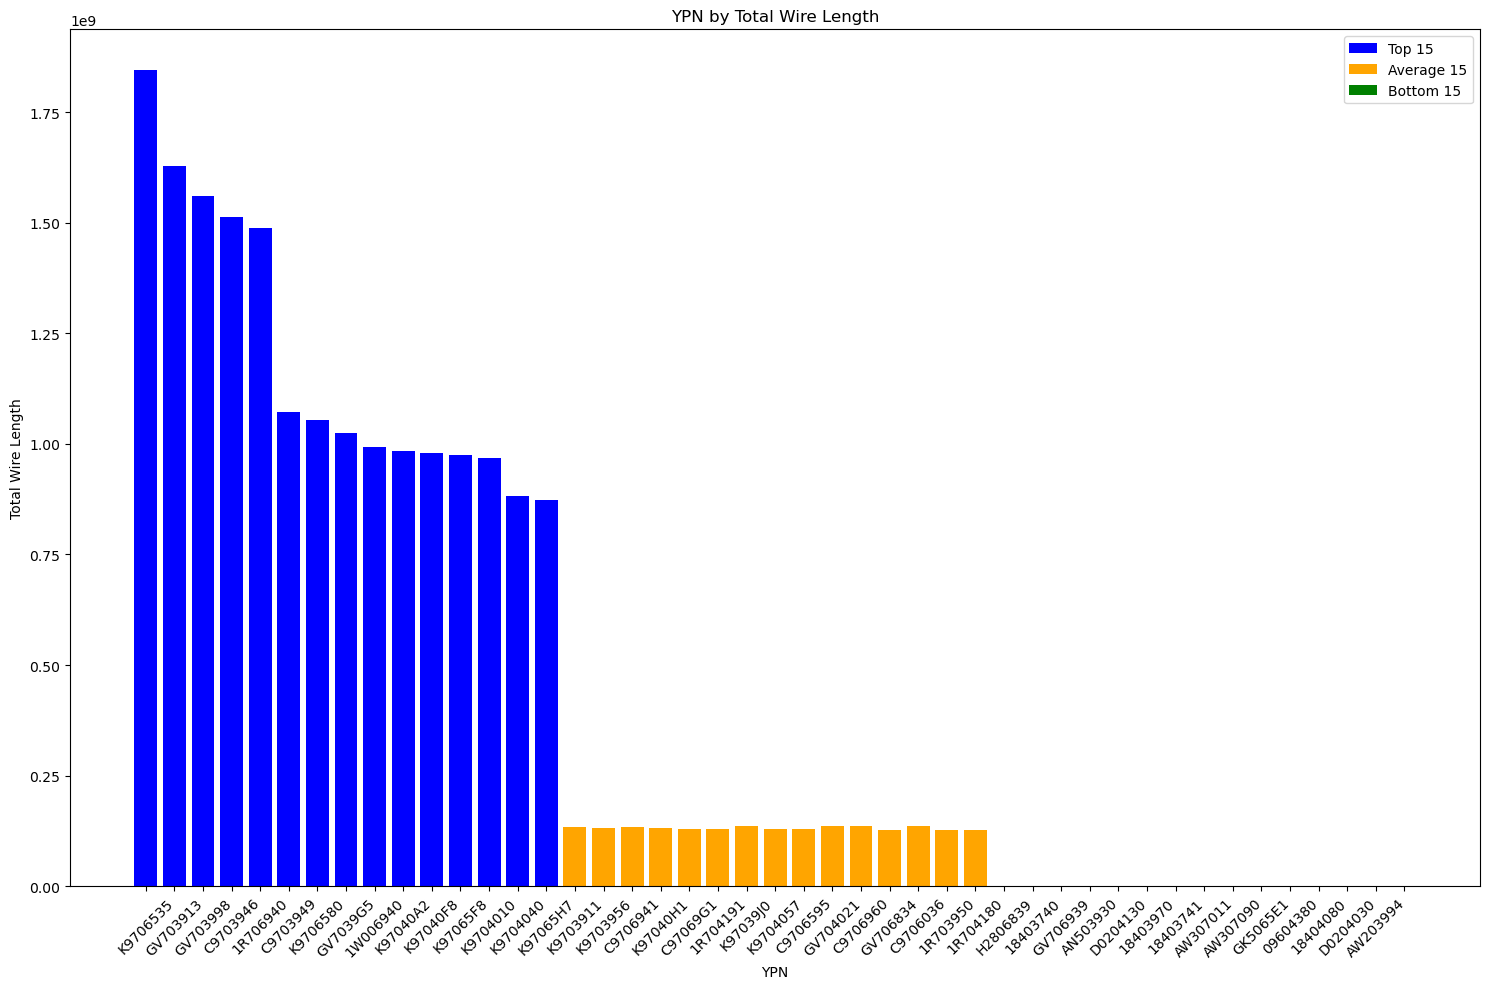

In [4]:



# Your query
query = """
WITH CombinedLengths AS (
    SELECT
        T.YPN1 AS YPN,
        SUM(T.Quantity * B1.WireLeftLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B1 ON T.SNumber = B1.CutleadNo AND T.YPN1 = B1.WireLeftIdentifier
    GROUP BY
        T.YPN1

    UNION ALL

    SELECT
        T.YPN2 AS YPN,
        SUM(T.Quantity * B2.WireRightLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B2 ON T.SNumber = B2.CutleadNo AND T.YPN2 = B2.WireRightIdentifier
    GROUP BY
        T.YPN2
),
AggregatedLengths AS (
    SELECT
        YPN,
        SUM(TotalLength) AS TotalWireLength
    FROM
        CombinedLengths
    GROUP BY
        YPN
)

SELECT
    YPN,
    TotalWireLength
FROM
    AggregatedLengths
ORDER BY
    TotalWireLength DESC;
"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql_query(query, con)

# Top 15 YPN
top15 = df.head(15)

# Bottom 15 YPN
bottom15 = df.tail(15)

# Calculate average TotalWireLength
average_length = df['TotalWireLength'].mean()

# 15 YPN closest to average TotalWireLength
df['DistanceToAvg'] = abs(df['TotalWireLength'] - average_length)
average15 = df.nsmallest(15, 'DistanceToAvg')

# Combine the data into a single DataFrame
combined_df = pd.concat([top15, average15, bottom15])
combined_df['Category'] = ['Top 15'] * len(top15) + ['Average 15'] * len(average15) + ['Bottom 15'] * len(bottom15)

# Plotting the results
fig, ax = plt.subplots(figsize=(15, 10))

colors = {'Top 15': 'blue', 'Average 15': 'orange', 'Bottom 15': 'green'}
for category, color in colors.items():
    subset = combined_df[combined_df['Category'] == category]
    ax.bar(subset['YPN'], subset['TotalWireLength'], label=category, color=color)

ax.set_title('YPN by Total Wire Length')
ax.set_xlabel('YPN')
ax.set_ylabel('Total Wire Length')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


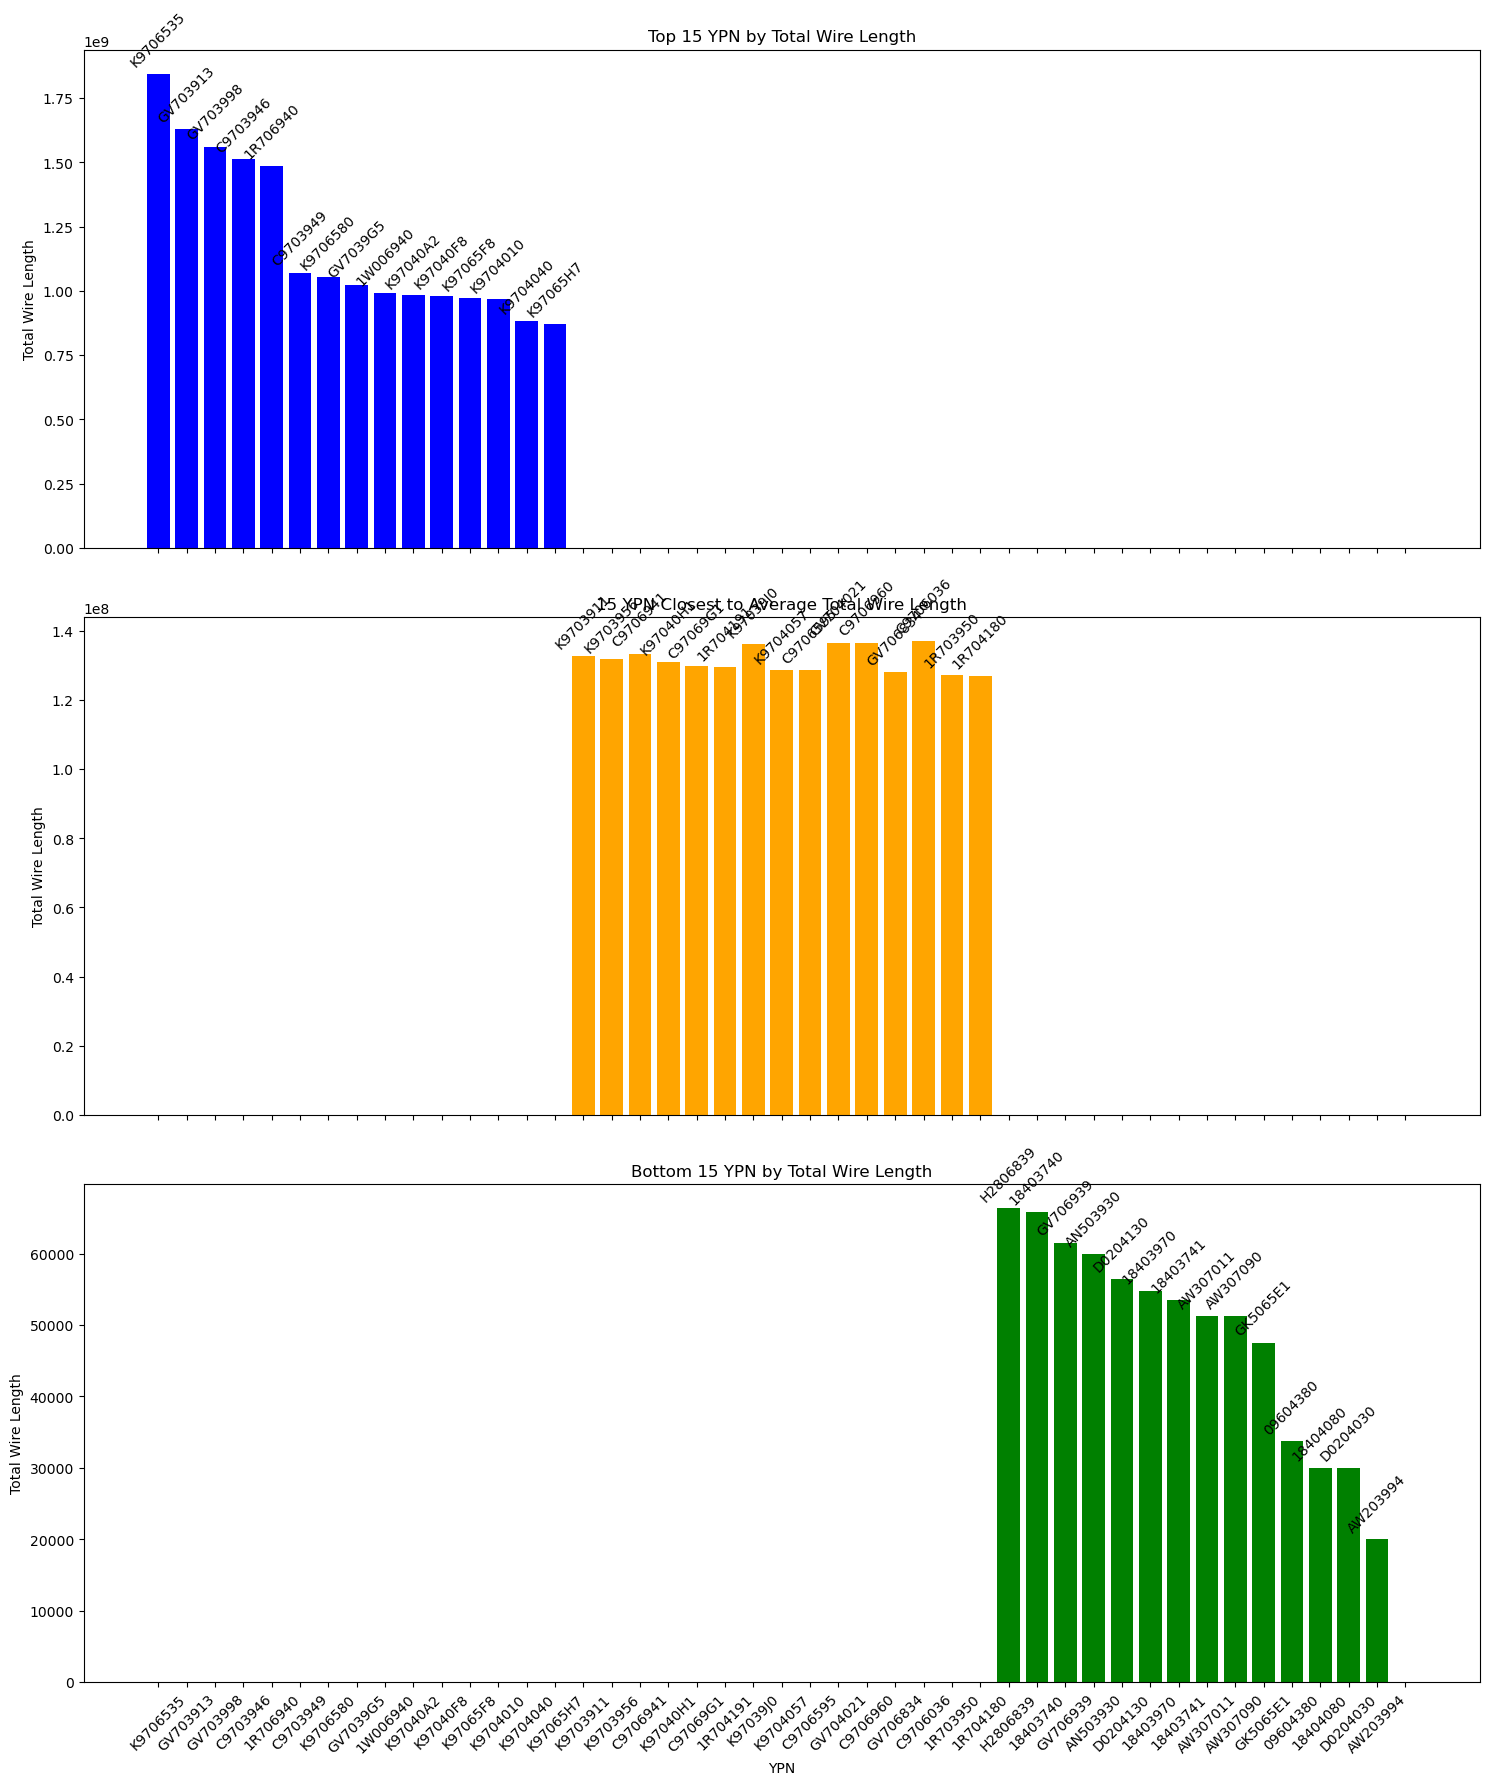

In [6]:
top15 = df.head(15)

# Bottom 15 YPN
bottom15 = df.tail(15)

# Calculate average TotalWireLength
average_length = df['TotalWireLength'].mean()

# 15 YPN closest to average TotalWireLength
df['DistanceToAvg'] = abs(df['TotalWireLength'] - average_length)
average15 = df.nsmallest(15, 'DistanceToAvg')

# Plotting the results
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# Top 15
bars1 = axes[0].bar(top15['YPN'], top15['TotalWireLength'], color='blue')
axes[0].bar_label(bars1, labels=top15['YPN'], rotation=45, padding=3)
axes[0].set_title('Top 15 YPN by Total Wire Length')
axes[0].set_ylabel('Total Wire Length')
axes[0].tick_params(axis='x', rotation=45)

# Average 15
bars2 = axes[1].bar(average15['YPN'], average15['TotalWireLength'], color='orange')
axes[1].bar_label(bars2, labels=average15['YPN'], rotation=45, padding=3)
axes[1].set_title('15 YPN Closest to Average Total Wire Length')
axes[1].set_ylabel('Total Wire Length')
axes[1].tick_params(axis='x', rotation=45)

# Bottom 15
bars3 = axes[2].bar(bottom15['YPN'], bottom15['TotalWireLength'], color='green')
axes[2].bar_label(bars3, labels=bottom15['YPN'], rotation=45, padding=3)
axes[2].set_title('Bottom 15 YPN by Total Wire Length')
axes[2].set_ylabel('Total Wire Length')
axes[2].tick_params(axis='x', rotation=45)

plt.xlabel('YPN')
plt.tight_layout()

plt.show()

In [7]:
query = """
WITH CombinedLengths AS (
    SELECT
        T.YPN1 AS YPN,
        T.Machines_Zone,
        SUM(T.Quantity * B1.WireLeftLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B1 ON T.SNumber = B1.CutleadNo AND T.YPN1 = B1.WireLeftIdentifier
    GROUP BY
        T.YPN1,
        T.Machines_Zone

    UNION ALL

    SELECT
        T.YPN2 AS YPN,
        T.Machines_Zone,
        SUM(T.Quantity * B2.WireRightLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B2 ON T.SNumber = B2.CutleadNo AND T.YPN2 = B2.WireRightIdentifier
    GROUP BY
        T.YPN2,
        T.Machines_Zone
),
AggregatedLengths AS (
    SELECT
        YPN,
        Machines_Zone,
        SUM(TotalLength) AS TotalWireLength
    FROM
        CombinedLengths
    GROUP BY
        YPN,
        Machines_Zone
)

SELECT
    YPN,
    Machines_Zone,
    TotalWireLength
FROM
    AggregatedLengths
ORDER BY
    TotalWireLength DESC;
"""

df = pd.read_sql_query(query, con)

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_1966/3497922742.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


In [8]:
pivot_df = top_5_wires_per_zone.pivot(index='YPN', columns='Machines_Zone', values='TotalWireLength')

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 6))

# Add title and labels
plt.title('Stacked Bar Chart of Top 5 Wires Used in Every Zone')
plt.xlabel('Wire Part Number (YPN)')
plt.ylabel('Total Wire Length')
plt.legend(title='Machines Zone', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

NameError: name 'top_5_wires_per_zone' is not defined

/var/folders/2d/2n_n07yd3rb6ng5gt08np8xm0000gn/T/ipykernel_16792/4079918888.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


<Figure size 1400x1000 with 0 Axes>

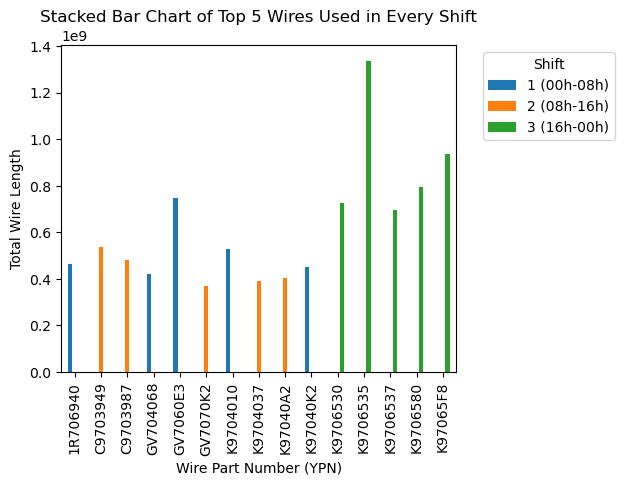

In [116]:
query = """
WITH CombinedLengths AS (
    SELECT
        T.YPN1 AS YPN,
        T.Shift,
        SUM(T.Quantity * B1.WireLeftLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B1 ON T.SNumber = B1.CutleadNo AND T.YPN1 = B1.WireLeftIdentifier
    GROUP BY
        T.YPN1,
        T.Shift

    UNION ALL

    SELECT
        T.YPN2 AS YPN,
        T.Shift,
        SUM(T.Quantity * B2.WireRightLength) AS TotalLength
    FROM
        YML3.dbo.YMT_3 T
    JOIN
        YML3.dbo.BOMCAO B2 ON T.SNumber = B2.CutleadNo AND T.YPN2 = B2.WireRightIdentifier
    GROUP BY
        T.YPN2,
        T.Shift
),
AggregatedLengths AS (
    SELECT
        YPN,
        Shift,
        SUM(TotalLength) AS TotalWireLength
    FROM
        CombinedLengths
    GROUP BY
        YPN,
        Shift
)

SELECT
    YPN,
    Shift,
    TotalWireLength
FROM
    AggregatedLengths
ORDER BY
    TotalWireLength DESC;
"""

# Load data into a DataFrame
df = pd.read_sql_query(query, con)

# Filter top 5 wires for each shift
top_5_wires_per_shift = df.groupby('Shift').apply(lambda x: x.nlargest(5, 'TotalWireLength')).reset_index(drop=True)



# Pivot the data to get the total wire length for each YPN in each shift
pivot_df = top_5_wires_per_shift.pivot(index='YPN', columns='Shift', values='TotalWireLength')

# Plot the stacked bar chart
plt.figure(figsize=(14, 10))
pivot_df.plot(kind='bar', stacked=False)
plt.title('Stacked Bar Chart of Top 5 Wires Used in Every Shift')
plt.xlabel('Wire Part Number (YPN)')
plt.ylabel('Total Wire Length')
plt.legend(title='Shift', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
